# flowField class for iterative solution

---------------------------------------------------

## Inheriting numpy.ndarray()

Reference: http://docs.scipy.org/doc/numpy/user/basics.subclassing.html

## Reading files into dictionary


In [ ]:
defaultDict = {'alpha':1.14, 'beta' : 2.5, 'omega':0.0, 'L': 0.0, 'M': 0.0, 'N': 0.0, 'K':0.0,
               'ReLam': 400.0, 'isPois':0.0, 'noise':0.0 , 'testvar':5.5}
for key in defaultDict:
    if key not in flowDict:
        flowDict[key] = defaultDict[key]
        print(key,flowDict[key],type(flowDict[key]))

## Defining flowField class that inherits np.ndarray

For starters, defining the class to initialize an empty ndarray along with a dictionary provided during initialization.

I need to verify that the dictionary being supplied has all the info I need to go with a flowField class. But, I can't verify this all the time. This is how I'll deal with it: 
* Verify the dictionary only when constructing a flowField class. So, that's when
    - Explicitly constructing an instance of the class
    - Viewing a given array as an instance of the class
* When slicing an array of the flowField class (to obtain another instance of the class), don't bother with the check. 

Basically, ensure every instance of the flowField class has a valid dictionary, and then stop worrying about it. 

So, we need a function that verifies the validity of dictionary, or creates one if one isn't supplied. The parameters required in the dictionary, and their defaults, are as follows:
* alpha : 1.14    
    *Wavenumber of fundamental streamwise Fourier mode*
* beta :  2.5    
    *Wavenumber of fundamental spanwise Fourier mode*
* omega: 0.0    
    *Fundamental frequency*
* ReLam: 400.0  
    *Reynolds number of the laminar base flow*
* isPois: 0     
    *Flag for base flow type. 0: Couette, 1: Poiseuille*
* noise: 0.0    
    *Norm of noise to be added to the flow*
* L: 0          
    *Number of (positive) harmonics of fundamental streamwise Fourier mode.*
* M: 0          
    *Number of (positive) harmonics of fundamental spanwise Fourier mode*
* N: 35         
    *Number of Chebyshev collocation nodes*
* K: 0         
    *Number of (positive) harmonics of fundamental frequency*

** For now, I'm ignoring the fact that np.ndarray can be viewed as a subclass. I'm defining the dictionary and checks in flowField.__new__(). Later, I'll have to move this to __array_finalize__ so that the dictionary is defined for cases when either an explicit constructor call is made or a view-casting is done**

### Ensure these features:
* View-casting:
    - ** View-casting a np.ndarray as flowField instance is not supported. Because view-casting does not allow any arguments, and the dictionary that accompanies the flowField array is fundamental. To make a flowField object out of an existing np.ndarray, use the constructor call. **
* Explicit construction:
    - Construct a randomField object based on noise levels supplied
* New from template:
    - Truncate and expand an instance of flowField to obtain a new instance with a changed dictionary (to reflect the truncation of L,M,N, or K)

***Try to minimize making copies of flowField objects***

** I have three cases to consider when building a flowField instance. Suppose L = 1**:
- The flowField has streamwise wavenumbers $-\alpha, 0, \alpha$
- The flowField only has streamwise wavenumbers $-\alpha, \alpha$
- The flowField only has streamwise wavenumber $\alpha$
    
This question becomes particularly important if only a half-plane or half-volume of the wavenumber space is considered. 

This is how I chose to resolve this issue. Considering L:
* If L = 0, then the flowField is of wavenumber $\alpha$
* If L = n ($\in \mathbb{N}$), then the flowField is resolved in wavenumbers {$0,\alpha,2\alpha,..,n\alpha$}.
* If L = -n ($n \in \mathbb{N}$), then the flowField is resolved in wavenumbers {$-n\alpha, (-n+1)\alpha,..,0,\alpha,...,n\alpha$}

This way, a flowField can be defined in three different ways for each of the three Fourier axes (streamwise, spanwise, temporal):
* As just one Fourier mode, $\alpha$ (which could be positive, negative, or zero). 
* As a collection of `n` harmonics (positive integer multiples of a positive/negative wavenumber), along with mode zero (the invariant mode).
* As a collection of `2n+1` harmonics, from $-n\alpha$ through $n\alpha$.

** Correction: For streamwise and temporal Fourier modes, the flowField class does not allow having just positive modes. We either have just one wavenumber (initialized with L=0 and/or K=0), of have 2L+1 and 2K+1 wavenumbers with both positive and negative**

I think this should be enough to deal with most cases. We will later need to define collections of flowFields. 

## Slice
I'm defining `slice` as a general method used for either truncating or extending the existing flowField instance. 

There are several cases to consider:
1.  Both existing and requested instances have the same wavenumber extension: either both contain positive and negative wavenumbers, or both contain only non-negative wavenumbers. For this case, there are 2 subcases:
    1.  The requested instance needs the existing instance to be truncated or held the same.
    2.  The requested instance needs the existing instance to be extended.
2.  The existing instance contains positive as well as negative wavenumbers, whereas the requested instance is only for positive wavenumbers. For this case:
    1.  The requested instance requires truncation in positive modes of the existing instance.
    2.  The requested instance requires extension in positive wavenumbers (with zeros for modes unavailable).
3.  The existing instance contains only positive wavenumbers, whereas the requested instance is for positive as well as negative. For this case too:
    1.  Truncation.
    2.  Extension.


## Going from half plane/volume to full using conjugate
I thought that if the Fourier modes available were $(0:K\omega,0:L\alpha, 0:M\beta)$, I could extend each set of modes into the negative side. But that's not true, I can only do that for just 1 set of modes. That is, I can't extend a quadrant to a full plane or an octant to a full volume. I can only go from 2 quadrants to 4, or 4 octants to 8. 

For now, I will suppose that we always have the flow resolved in the half-plane or the half-volume $\beta>0$. So, K,L are always negative (-0=0). Only M is allowed to be positive, but it could also be set to be negative. 

**With this simplification, cases 2 and 3 identified for slicing (above) only relate to M. For K and L, it's always case 1.**



## Linearizing convection term about a base flow

$\chi = \chi_b + \chi_f$ 
    where $\chi_b$ is the base flow and $\chi_f$ the perturbation


$\begin{align}
(\chi.\nabla)\chi &= ((\chi_b+\chi_f).\nabla)(\chi_b+\chi_f)\\
        &\approx \chi_b.\nabla \chi_b + \chi_b.\nabla \chi_f + \chi_f.\nabla \chi_b \\
\implies (\chi.\nabla)\chi - (\chi_b.\nabla)\chi_b &= \chi_b.\nabla \chi_f + \chi_f.\nabla \chi_b = C_l
\end{align}$ 

With the domain transformation stuff, the non-linear terms for stability analysis is going to be a pain to deal with- because when the fluctuation has a wavenumber which isn't an integral multiple of the surface wavenumber, the nice Fourier resolution that I have going right now will get messed up. For today, I'll do this part without worrying about the domain transformation. Just plain old LSA. 

Supposing $\chi_b = [U(y),0,0]$, with $\chi_f = [u_f(y), v_f(y), w_f(y)] e^{i(\alpha x + \beta z - \omega t)}$, and dropping the subscript 'f' henceforth:

$C_l[0] = U u_x + v U' \\
C_l[1] = U v_x \\
C_l[2] = U w_x $

## Dot products for different flowField instances

Inner products are defined as follows (supposing, WLG, only 2D scalars):

$\begin{align}
u^1(x,y) &= \Sigma_l u^1_l(y) e^{il\alpha_1 x}\\
u^2(x,y) &= \Sigma_m u^2_m(y) e^{im\alpha_2 x}\\
<u^1, u^2> &= \\
\end{align}$

## Adapting flowField class for transformed domains

My initial plan was to do something like this
    * Define flowField.ddx(), .ddy(),..., along with .grad(), .laplacian(), etc..
    * Have keyword arguments passed to .grad(), etc.. that refer to the partial derivatives. For flat-walled flows, the keyword arguments default to .ddx(), .ddy(), .ddz()
    * For transformed domains, pass functions other than the default .ddx(), etc.. to reflect the coordinate transformation. For instance, pass partialX = self.ddx() + Tfun*self.ddy()


But I think that would complicate things a bit too much. So, new strategy:
    * No keyword arguments for .grad(), etc... They always call self.ddx(), self.ddy(), self.ddz().
    * Overload .ddx(), .ddy(), .ddz() in the subclass of flowField

If I make methods such as .grad() use self.ddx() instead of flowField.ddx(), then then the overloaded methods would be used. That's all I need. 

## Making uBase more generic

The current version of the code takes uBase to be just [$u_{000}$(y), 0,0]. 

I need to extend this to more general cases, either for domain transformation or for higher classes of base flows, where uBase is a bigger vector with 3C along different Fourier modes. 

## Adding attributes kArr, lArr, mArr

Currently, the default for Fourier mode wavenumbers is integer multiples of $\omega, \alpha,\beta$. So, whenever a partial derivative along x,z, or t is requested, I create `kArr`, `lArr`, and `mArr` as arrays of integers. 

But for domain transformation problems, there are two length scales- the scale of the field variables (especially for fluctuations), and the scale of the surface-waviness. When these two length scales are not low integer multiples, I will have to have `kArr`, `lArr`, and `mArr`with non-integer entries. The simplest way to implement this, that I can think of right now, is to define the arrays as attributes of the flowField during initialization.

For the domain transformation cases, I can initialize using the default integer arrays, and then add a constant to reflect the wavenumber of the field variable. 

## Introducing kOffset, lOffset, mOffset instead of kArr, lArr, mArr

The reason that I wanted to introduce kArr, lArr, mArr above was so the class could deal with, most importantly, the following case:
    If a fluctuation with wavenumbers that are not integer multiples of the wavenumbers of the existing base flow is introduced, its energy would disperse (linearly) into wavenumbers that are, again, not integer multiples of wavenumbers of the base flow. 
    
But, the dispersion would only be into wavenumbers that are offset by a constant amount. 

To illustrate, suppose the base flow has modes of wavenumbers (-3a,-2a,-a,0,a,2a,3a). If a fluctuation of wavenumber 1.3a is introduced, its energy would disperse linearly (due to the base flow) into wavenumbers(-1.7,-0.7,0.3,1.3,2.3,3.3,4.3)a. 

Even for wavy walled flows, the above relation holds as long as only solutions periodic in surface waviness are considered. 

Instead of defining an lArr to indicate the wavenumbers to which energy has dispersed, I can simply say that it's still the same (-3,-2,-1,0,1,2,3)a, except with an offset of 1.3a. 

## Testing flowField class with exact solutions 

In [ ]:
import scipy as sp
import numpy as np
from pseudo import *

f = np.genfromtxt('eq1.asc',dtype=np.complex)
f_p = np.genfromtxt('peq1.asc',dtype=np.complex)
   
x = f[:,3];x_p = f_p[:,3]

# From the database at channelflow.org
Re=4.0e2
a=1.14
b=2.5

nx = 48
nz = 25
L = 24
M = 24
N = 35

# In input file, ordering of modes is different from what I would like it to be.
# It goes, 0,1,..,24,-23,-22,....,-1 in 'x'
# I prefer, -23,-22,..,-1,0,1,...,22,23
# In 'z', it's just 0,..,24 
#     Negative wavenumbers are not included due to symmetry.

# First, getting rid of mode 24 in both x and z 
modes = x.reshape((nx,nz,3,N))
modes = sp.append(modes,x_p.reshape((nx,nz,1,N)),axis=2)
modes = sp.delete(modes,L,0)
modes = sp.delete(modes,M,1)


nx = nx-1 
nz = nz-1
L = L-1
M = M-1

# Now, reordering streamwise wavenumbers
modes = sp.append(modes[L+1:,:,:,:],modes[:L+1,:,:,:],0)
del x,x_p,f,f_p


# Projecting Cheb coefficients onto Cheb collocation nodes
for kx in range(0,nx):
    for kz in range(0,nz):
        for nd in range(0,4):
            modes[kx,kz,nd,:] = chebcoll_vec(modes[kx,kz,nd,:])

# Adding modes for negative spanwise wavenumbers. 
#modes = sp.append(sp.append(modes[:15:-1,:0:-1,:,:].conjugate(),modes[15::-1,:0:-1,:,:].conjugate(),axis=0),modes,axis=1)
modes = sp.append(modes[::-1,:0:-1].conjugate(),modes,axis=1)
nz = nx

#modes = modes[15:nx-15, 15:nz-15,:,:]
#nx = nx-30
#nz = nz-30
#L = L-15
#M = M-15


#p_temp = modes[:,:,3]
## Removing boundary nodes:
#modes = sp.delete(modes,(0,N-1),3)

# Deleting pressure from state-vector:
p = modes[:,:,3]
modes = sp.delete(modes,3,2)

## Deleting wall-normal velocity from state-vector:
# v = modes[:,:,1,:]
# modes = sp.delete(modes,1,2)

## Defining wall-normal grid, and differentiation matrices
#y,DM = chebdif(N,2)
#D = DM[:,:,0]
#D2 = DM[:,:,1]

vecsize = nx*nz*N
# Finally, reshaping to get a state-vector containing u and w
x0 = modes.reshape(3*vecsize)
p = p.reshape(vecsize)
del modes
#print(modes[L,M,0])


In [ ]:
from flowField import *
tempDict = getDefaultDict()
tempDict['M'] = -23
tempDict['nd'] = 3
vField1 = flowField(flowDict=tempDict.copy()); vField1.verify()
tempDict['nd'] = 1
pField1 = flowField(flowDict=tempDict.copy()); pField1.verify()

residuals1 = vField1.residuals(pField=pField1,nonLinear=True)
print('Norm of residual:',residuals1.norm())
#print('From earlier version, Norm is supposed to be ~ 2.6876e-06')

pNew1, resids1 = vField1.solvePressure(residuals=residuals1, pField=pField1, nonLinear=True, divFree=False)
print('Norm of correction in pField with solvePressure:',(pField1-pNew1).norm())
print('Norm after correction in pField',resids1.norm())

#norm(vField.div())
#vField.div().intY().shape


In [ ]:
tempDict = getDefaultDict()
tempDict['M'] = -23
tempDict['isPois'] = 1
print('Verifying residual for Poiseuille flow')
tempDict['nd'] = 3
vField1 = flowField(flowDict=tempDict.copy()); vField1.verify()
tempDict['nd'] = 1
pField1 = flowField(flowDict=tempDict.copy()); pField1.verify()

residuals1 = vField1.residuals(pField=pField1,nonLinear=True)
print('Norm of residual:',residuals1.norm())
#print('From earlier version, Norm is supposed to be ~ 2.6876e-06')

pNew1, resids1 = vField1.solvePressure(residuals=residuals1, pField=pField1, nonLinear=True, divFree=False)
print('Norm of correction in pField with solvePressure:',(pField1-pNew1).norm())
print('Norm after correction in pField',resids1.norm())

In [ ]:
Re = vField.flowDict['Re']
print('Laplacian norm:',(1/Re*vField).laplacian().norm())
print('pGrad norm:',pField.grad().norm())
print('Convection (linear) norm:', vField.convLinear().norm())
print('Divergence norm:', vField.div().norm())

## Reading data from .mat files into flowFieldArray class instance
Makes it easier to calculate variables, and to plot

1. Reading .mat files from a folder, according to a template, into a Python list
2. Converting that Python list into flowFieldArray instance (class defined in module flowFieldArray.py)

In [2]:
# Reading all the .mat files takes a while, so this chunk of code needs to be separate from the other stuff
import glob
import os
from flowFieldWavy import *
from flowFieldArray import *
homeFolder = '/home/sabarish/Dropbox/gitwork/python3/flowField/'
folderPath = '/home/sabarish/matData/drag/'
fileTemplate = "data_dragT0E*.mat" 

os.chdir(folderPath)
fileList = glob.glob(fileTemplate)
for file in fileList[:]:
    if (file[-6:] =='13.mat') or (file[-6:] =='14.mat') or (file[-6:] =='15.mat'):
        #print(file)
        fileList.remove(file)

vListLong =[]; pListLong = []
for file in fileList:
    vList,pList = data2ff(file)[:2]
    vListLong.extend(vList)
    pListLong.extend(pList)
os.chdir(homeFolder)

In [ ]:
# %load flowFieldArray.py
"""
flowFieldArray: Class that defines arrays of flowField objects
3-D numpy arrays are used, with axes 0,1,2 referring to eps,g,Re

Additionally, a class
flowFieldArray4D may also be defined (later) to allow handling inclinations (beta)"""
from flowField import *
from flowFieldWavy import *
import numpy as np

class flowFieldArray(np.ndarray):
    """Defines a numpy.ndarray object
    Input should be a list of flowField instances, which are then sorted along axes 0,1,2 by eps,g, Re
    Note: Currently, the class needs to know the number of eps, g, Re to work,
            given by arguments neps,ng,nRe"""
    def __new__(cls,fieldList,neps,ng,nRe):
        assert len(fieldList) == neps*ng*nRe, "Length of fieldList is not consistent with neps,ng,nRe"
        objList = np.asarray([flowFieldArrayObject(field) for field in fieldList])
        epsArr = np.asarray([field.eps for field in objList])
        epsInd = np.argsort(epsArr)   # Sort indices by increasing eps
        objList = objList[epsInd].reshape((neps,ng*nRe))
        
        for keps in range(neps):
            gArr = np.asarray([field.g for field in objList[keps]])
            gInd = np.argsort(gArr)
            objList[keps] = objList[keps,gInd]
        
        objList = objList.reshape((neps,ng,nRe))
        for keps in range(neps):
            for kg in range(ng):
                ReArr  = np.asarray([field.Re for field in objList[keps,kg]])
                ReInd = np.argsort(ReArr)
                objList[keps,kg] = objList[keps,kg,ReInd]
        obj = objList.view(cls)
        obj.neps = neps
        obj.ng = ng
        obj.nRe = nRe
        return obj
        
    def __array_finalize__(self,obj):
        if isinstance(obj, flowFieldArray):
            if self.ndim == 3:
                self.neps = self.shape[0]; self.ng = self.shape[1]; self.nRe = self.shape[2]
            else:
                self.neps = getattr(self,'neps',obj.neps)
                self.ng = getattr(self,'ng',obj.ng)
                self.nRe = getattr(self,'nRe',obj.nRe)
            return
        
    def getProperty(self,propStr,**kwargs):
        try:
            propArr = np.asarray([getattr(element,propStr) for element in self.reshape(self.size)])
        except AttributeError:
            try:
                propArr = np.asarray([getattr(element.field,propStr)(**kwargs) for element in self.reshape(self.size)])
            except TypeError: 
                propArr = np.asarray([getattr(element.field,propStr) for element in self.reshape(self.size)])
            except: "Attribute doesn't exist for either flowField"
        return propArr.reshape(self.shape)
        
    
class flowFieldArrayObject:
    """Defines an object that contains flowFields, as well as eps,g,alpha,beta,Re as attributes"""
    def __init__(self,field=None):
        if field is None:
            self.field=None; self.eps=None; self.g=None; self.a=None; self.b=None; self.Re=None
        else:
            self.setField(field)
    
    def setField(self,field):
        assert isinstance(field,flowField), "Argument 'field' must be an instance of flowField"
        self.field=field
        self.eps = field.flowDict['eps'];  self.a = field.flowDict['alpha']; self.b = field.flowDict['beta']
        self.Re = field.flowDict['Re']; self.ReTau = np.sqrt(2.*self.Re)
        if self.a != 0.: self.g = self.a*self.eps
        else: self.g = self.b*self.eps    


In [3]:
# Create flowFieldArray instance out of the list of flowField instances
vArr = flowFieldArray(vListLong,26,24,21)

# To obtain a 3-d array of, say, volume fluxes of the data in the flowFieldArray:
fluxArr = vArr.getProperty('flux')
#ReTauArr = vArr.getProperty('ReTau')

AttributeError: 'flowFieldWavy' object has no attribute 'ReTau'

In [15]:
vF.N()

TypeError: 'int' object is not callable

4 <class '__main__.flowFieldArray'>
[[[ -3.97123897e-05  -3.97123891e-05  -3.95268308e-05]
  [ -1.01745986e-04  -1.01745986e-04  -1.01745986e-04]
  [ -2.37681471e-04  -2.37681472e-04  -2.37681474e-04]
  [ -4.10209378e-04  -4.10209423e-04  -4.10209410e-04]]

 [[ -5.45085589e-05  -5.45085577e-05  -5.45085556e-05]
  [ -1.10441119e-04  -1.10441119e-04  -1.10441118e-04]
  [ -2.19269317e-04  -2.19269352e-04  -2.19269349e-04]
  [ -3.79203990e-04  -3.79204010e-04  -3.79203996e-04]]

 [[ -7.31003447e-05  -7.31003433e-05  -7.31003409e-05]
  [ -1.39310803e-04  -1.39310801e-04  -1.39310800e-04]
  [ -2.30899474e-04  -2.30899574e-04  -2.30899573e-04]
  [ -3.72674413e-04  -3.72674406e-04  -3.72674410e-04]]

 [[ -1.00213662e-04  -1.00213661e-04  -1.00213658e-04]
  [ -1.89153740e-04  -1.89153737e-04  -1.89153733e-04]
  [ -2.78662775e-04  -2.78663072e-04  -2.78663069e-04]
  [ -4.05477774e-04  -4.05477774e-04  -4.05477774e-04]]

 [[ -1.33751366e-04  -1.33751356e-04  -1.33751339e-04]
  [ -2.58355388e-04  

In [ ]:
# %load flowField.py
''' 
#####################################################
Author : Sabarish Vadarevu
Affiliation: Aerodynamics and Flight Mechanics group, University of Southampton.


non-class functions:
getDefaultDict(), verify_dict(), read_dictFile(), makeVector()
'''

import numpy as np
import scipy as sp
#from scipy.linalg import norm
from warnings import warn
from pseudo import chebdif, clencurt, chebintegrate, chebint
#from pseudo.py import chebint

defaultDict = {'alpha':1.14, 'beta' : 2.5, 'omega':0.0, 'L': 23, 'M': 23, 'nd':3,'N': 35, 'K':0,
               'Re': 400.0, 'isPois':0.0, 'noise':0.0 , 'lOffset':0.0, 'mOffset':0.0}

defaultBaseDict = {'alpha':0, 'beta' : 0, 'omega':0.0, 'L': 0, 'M': 0, 'nd':1,'N': 35, 'K':0,
               'Re': 400.0, 'isPois':0.0, 'noise':0.0 , 'lOffset':0.0, 'mOffset':0.0}

divTol = 1.0e-06
pCorrTol = 1.0e-04


    

def getDefaultDict(base=False):
    if base:
        return defaultBaseDict.copy()
    else:
        return defaultDict.copy()

def verify_dict(tempDict):
    '''Verify that the supplied flowDict has all the parameters required'''
    change_parameters = False
    if tempDict is None:
        tempDict = defaultDict.copy()
        warn('No flowDict was supplied. Assigning the default dictionary')
    else: 
        for key in defaultDict:
            assert key in tempDict, 'Some dictionary keys are missing'
    [tempDict['K'],tempDict['L'],tempDict['N'],tempDict['isPois']] = [int(abs(k)) for k in [tempDict['K'],tempDict['L'],tempDict['N'],tempDict['isPois']]]
    tempDict['M'] = int(tempDict['M'])
    if tempDict['alpha'] == 0.: assert tempDict['L'] == 0, 'If alpha is zero, L should also be set to zero in the dictionary'
    if tempDict['beta'] == 0.: assert tempDict['M'] == 0, 'If beta is zero, M should also be set to zero in the dictionary'
    if tempDict['omega'] == 0.: assert tempDict['K'] == 0, 'If omega is zero, K should also be set to zero in the dictionary'
    return tempDict

def read_dictFile(dictFile):
    '''Read flowDict from file. MUST use "flowConfig.txt" as template. '''
    tempDict = {}
    with open("flowConfig.txt",'r') as f:
        for line in f:
            (key,val) = line.split()[:2]
            tempDict[key] = float(val)    
    return tempDict

def makeVector(*args):
    '''Concatenate flowField objects. Use this to create a vector flowField from scalar/vector flowFields
    For instance,   uvw = makeVector(u,v,w)
                    uvwp = makeVector(u,v,w,p) = makeVector(uvw,p)'''
    ff = args[0]
    if not isinstance(ff,flowField):
        raise RuntimeError('makeVector takes as arguments only instances of flowField class')
        return
    for v in args[1:]:
        if not isinstance(v,flowField):
            raise RuntimeError('makeVector takes as arguments only instances of flowField class')
        ff = ff.appendField(v)
    return ff
    

class flowField(np.ndarray):
    '''
    This module provides a class to define u,v,w (or scalars such as pressure) in 4D: t, x,z,y. 
    The shape of a class instance is (nt,nx,nz,nd,N): nt,nx,nz are harmonics (in omega, alpha,beta) 
        of Fourier modes in t,x,z respectively.
    nd is the number of components, 3 for [u,v,w]. 
    Scalars and non-3d fields can be created by setting 'nd' appropriately (nd=1 for scalars).
    N refers to Chebyshev collocation nodes

    Class attributes:
        self:   np.ndarray of shape (nt,nx,nz,nd,N)
        nt, nx, nz : length of axes 0,1, and 2 respectively
        nd:     Number of components of vector field. =1 for scalars. Length of axis 3
        N:      Number of Chebyshev collocation nodes.
        lOffset:When non-zero, indicates that the streamwisemodes are not harmonics of 
                    fundamental frequency (alpha) but are offset from harmonics by a constant `lOffset`
        mOffset:Same as lOffset, for spanwise modes
        flowDict: 
            defaultDict = {'alpha':1.14, 'beta' : 2.5, 'omega':0.0, 'L': 23, 'M': 23, 'nd':3,'N': 35, 'K':0,
                   'Re': 400.0, 'isPois':0.0, 'noise':0.0 }
            'noise' is currently not implemented, but will later be used to initialize "random" flowField instances


    Methods (names only. See doc-strings for methods for template): 
        verify. view1d, view4d 
        slice, getScalar, appendField, copyArray
        real, imag, conjugate, abs
        ddt, ddx, ddx2, ddz, ddz2, ddy, ddy2, intX, intY, intZ
        grad3d, grad2d, grad, div, laplacian, curl3d, curl
        convLinear, convNL, convSemiLinear
        dot, sumAll, norm
        residuals, solvePressure
        ifft, getPhysical, makePhysical, makePhysicalPlanar

    It must always be ensured that the dictionary, self.flowDict, is always consistent with the flowField instance.
    Unless one is absolutely sure that the dictionary attributes don't need to be changed, 
        the arrays should not be accessed directly. Either the methods must be used, 
        or for cases when a method isn't appropriate, the dictionary must be appropriately modified.

    self.verify() ensures that at least the shape attributes are self-consistent. 
    alpha, beta, omega, Re are not verified with self.verify()

    Provides 4d scalars and vectors of shape (nt,nx,nz,nd,N),
    nt, nx, nz: Number of temporal, streamwise, and spanwise Fourier modes contained in the flowField. 
    nd: Number of components of the vector
    N: Number of Chebyshev collocation nodes (on [1,-1])
    nt,nx,nz,nd,N, and a bunch of other parameters: Re, alpha, beta, omega, isPois (flag to say if flow is pressure driven or driven by plate motion)
        are taken from a dictionary that MUST accompany the field array. The class fails to work when the dictionary is not consistent

    Initialization:
        flowField() creates an instance using a default dictionar: a 3 component vector of shape (1,47,24,3,35).
        flowField(flowDict=dictName) creates an instance with shape attributes as defined in the dictionary.
            If the dictionary does not have all the keys needed, an assertion error is printed
        flowField(dictFile='flowConfig.txt') creates an instance using the attributes defined in the file flowConfig.txt
            The file flowConfig.txt has its lines formatted to facilitate being read by a function in this module. DO NOT EDIT IT except for the values
        flowField(arr=initArr, flowDict=dictName)
            Unless an array is passed using the keyword 'arr', the instance is initialized with zeros

    All three arguments can be used to provide a dictionary (arr can be an instance of flowField).
    flowDict argument has highest priority in defining the dictionary, 
        followed by dictFile
        followed by arr.flowDict (when arr is an instance of flowField or its subclass)
    If none of the above arguments provide a flowDict, a default dictionary (defined in the module) is used.
    A warning message is printed when the default dictionary is used.
            
    '''
    def __new__(cls, arr=None, flowDict=None, dictFile= None):
        '''Creates a new instance of flowField class with arguments (arr=None,flowDict=None,dictFile=None)
        '''
        if flowDict is None:
            if dictFile is None:
                if hasattr(arr,'flowDict'):
                    flowDict = arr.flowDict
                else:
                    flowDict=verify_dict(flowDict)
            else:
                flowDict = verify_dict(read_dictFile(dictFile))
        else:
            flowDict = verify_dict(flowDict)
        
        L = flowDict['L']
        M = flowDict['M']
        N = flowDict['N']
        K = flowDict['K']
        nd = flowDict['nd']
        nt = 2*K+1
        nx = 2*L+1
        nz = int(3.*abs(M)/2. - M/2. + 1)     # = 1 if M=0;    = M+1 if M>0;    = 2*|M|+1 if M<0
        
        if arr is None:
            #obj =  np.zeros((nt,nx,nz,nd,N),dtype=np.complex).view(cls)
            obj = np.ndarray.__new__(cls,shape=(nt,nx,nz,nd,N),dtype=np.complex,buffer=np.zeros(nt*nx*nz*nd*N,dtype=np.complex))
        else:
            if arr.dtype == np.float:
                arr = (arr+1.j*np.zeros(arr.shape))
            obj = np.ndarray.__new__(cls,shape=(nt,nx,nz,nd,N),dtype=np.complex,buffer=arr)
        
        #print(norm(obj))
        
        if obj.size != (nx*nz*nt*nd*N):
            raise RuntimeError('The parameters in the dictionary are not consistent with the size of the supplied array')
        
        obj.flowDict = flowDict
        obj.nx = nx
        obj.nz = nz
        obj.nt = nt
        obj.N = N
        obj.nd = flowDict['nd']
        yCheb = chebdif(N,1)[0]
        if flowDict['isPois'] == 1: obj.uBase = 1.-yCheb**2
        elif flowDict['isPois'] == 0: obj.uBase = yCheb
        else: raise RuntimeError("flowDict key 'isPois' must be either 0 or 1")
        
        return obj
        
    
    def __array_finalize__(self,obj):
        if self.dtype != np.complex:
            print('Shape of self that is giving dtype errors:',self.shape)
            warn('flowField class is designed to work with complex array entries\n'+
                 'To obtain real/imaginary parts of an instance, use class methods "real()" and "imag()"')
        if isinstance(obj, flowField):
            self.flowDict = getattr(self,'flowDict',obj.flowDict.copy())
            self.nt = getattr(self,'nt',obj.nt)
            self.nx = getattr(self,'nx',obj.nx)
            self.nz = getattr(self,'nz',obj.nz)
            self.nd = getattr(self,'nd',obj.nd)
            self.N = getattr(self,'N',obj.N)
            self.uBase = getattr(self,'uBase',obj.uBase)
            return
        elif obj != None:
            raise RuntimeError('View-casting np.ndarray is not supported since dictionaries cannot be passed. \n'+
                               'To initialize class instance from np.ndarray, use constructor call:flowField(arr=myArray,dictFile=myFile)')
        return

    
    def verify(self):
        '''Ensures that the size of the class array is consistent with the dictionary entries. 
        Use this when writing new methods or tests'''
        self.flowDict = verify_dict(self.flowDict)
        if not ((self.nt == 2*self.flowDict['K']+1) and (self.nx == 2*self.flowDict['L']+1) and 
                (self.nz == int(3.*abs(self.flowDict['M'])/2. - self.flowDict['M']/2. + 1)) and
                (self.N == self.flowDict['N']) and (self.nd == self.flowDict['nd'])): 
            raise RuntimeError('The shape attributes of the flowField instance are not consistent with dictionary entries')
        assert self.size == self.nt*self.nx*self.nz*self.nd*self.N, 'The size of the flowField array is not consistent with its shape attributes'
        
        
    def view1d(self):
        ''' Returns a 1d view. 
        Don't try to figure out what the ordering is, just use self.view4d() to get an organized view'''
        return self.reshape(self.size)
    
    def view4d(self):
        ''' Returns a 4d view (actually, a 5-D array): (omega, alpha, beta, field=u,v,w,p, N)'''
        return self.reshape((self.nt,self.nx,self.nz,self.nd,self.N))

    def slice(self,K=None,L=None,M=None,nd=None,N=None):
        '''
        Returns a class instance with increased/reduced K,L,M,nd,N
        Call as new_inst = myFlowField.slice(K=Knew,L=Lnew,N=Nnew)) to change values of K,L,N without affecting M (and nd)
        When the number of Fourier modes (K,L,M, or nt,nx,nz) are smaller than what is requested, 
            additional zero modes are added. For Chebyshev nodes, interpolation is used'''
        obj = self.copyArray()
        nxt = self.nx
        ntt = self.nt
        nzt = self.nz
        ndt = self.nd
        Nt = self.N
        flowDict_temp = self.flowDict.copy()
        if (K is not None) and (K != self.flowDict['K']):
            K = int(abs(K))
            Kt = flowDict_temp['K']               # Temporary name for 'K' of self
            if K <= Kt:
                obj = obj[Kt-K:Kt+K+1]
            else: 
                obj = np.concatenate((  np.zeros((Kt-K,nxt,nzt,ndt,Nt),dtype=np.complex), obj,
                               np.zeros((Kt-K,nxt,nzt,ndt,Nt),dtype=np.complex)  ), axis=0)
            flowDict_temp['K']= K
            ntt = 2*K+1
        
        if (L is not None) and (L != self.flowDict['L']):
            L = int(abs(L))
            Lt = flowDict_temp['L']               # Temporary name for 'L' of self
            if L <= Lt:
                obj = obj[:,Lt-L:Lt+L+1]
            else: 
                obj = np.concatenate((  np.zeros((ntt,abs(Lt-L),nzt,ndt,Nt),dtype=np.complex), obj,
                               np.zeros((ntt,abs(Lt-L),nzt,ndt,Nt),dtype=np.complex)  ), axis=1)
            flowDict_temp['L']= L
            nxt = 2*L+1
        
        if (M is not None) and (M != self.flowDict['M']):
            M = int(M)
            Mt = flowDict_temp['M']               # Temporary name for 'M' of self
            nzt = int(3.*abs(M)/2. - M/2. + 1)     # = 1 if L=0;    = L+1 if L>0;    = 2*|L|+1 if L<0
            
            if M*Mt >=0: 
                if abs(M) <= abs(Mt): # Case 1.A: Truncate
                    nz0 = int((abs(Mt)-Mt)/2)     # = Mt for Mt< 0, = 0 otherwise
                    nzm1 = nz0 - int((abs(M)-M)/2) 
                    nzp1 = nz0 + abs(M) + 1
                    obj = obj[:,:,nzm1:nzp1]
                else:  # Case 1.B: Extend using zero modes
                    nzplus = int(abs(M)-abs(Mt))
                    if M<0: 
                        obj = np.concatenate(( np.zeros((ntt,nxt,abs(Mt-M),ndt,Nt),dtype=np.complex), obj,
                               np.zeros((ntt,nxt,abs(Mt-M),ndt,Nt),dtype=np.complex)  ), axis=2)
                    else:
                        obj = np.concatenate(( obj,
                               np.zeros((ntt,nxt,abs(Mt-M),ndt,Nt),dtype=np.complex) ), axis=2)
            elif M > 0:          # Case 2: Get only modes [0,b,..,|M|b] from [-|Mt|*b,..,0,b,..,|Mt|*b]
                if abs(M) <= abs(Mt): # Case 2.A: |M|< |Mt|, so truncate
                    nz0 = int((abs(Mt)-Mt)/2)
                    nzp1 = nz0 + M + 1
                    obj = obj[:,:,nx0:nzp1]
                else:    # Case 2.B: |M| > |Mt|, so add zero modes 
                    obj = np.concatenate(( obj[:,:,abs(Mt):], 
                               np.zeros((ntt,nxt,abs(Mt-M),ndt,Nt),dtype=np.complex) ), axis=2)
            else: # Case 3: Get modes [-|M|b,...,0,b,..,|M|b], given [0,b,..,|Mt|b]
                if abs(M) <= abs(Mt):        # Case 3.A: Truncate on positive, extend with conjugates on negative
                    obj = np.concatenate(( obj[::-1,::-1,abs(M):0:-1].conjugate(), obj[:,:,:abs(M)+1] ), axis=2)
                else:            # Case 3.B: Extend on positive with zeros, extend on negative with conjugates and zeros
                    # Doing the extension with conjugates on negative first:
                    obj = np.concatenate(( obj[::-1,::-1,:0:-1].conjugate(), obj ), axis=2)
                    # Adding zeros on positive and negative:
                    obj = np.concatenate((  np.zeros((ntt,nxt,abs(Mt-M),ndt,Nt),dtype=np.complex), obj,
                               np.zeros((ntt,nxt,abs(Mt-M),ndt,Nt),dtype=np.complex) ), axis=2)
            flowDict_temp['M']= M
        
        if (N is not None) and (N != self.flowDict['N']):
            N = abs(int(N))
            Nt = flowDict_temp['N']
            if N != Nt:
                y = chebdif(N,1)[0]
                obj_t = obj.reshape((obj.size//Nt,Nt))
                obj = np.zeros((obj_t.size//Nt,N),dtype=np.complex)
                for n in range(obj_t.size//Nt):
                    obj[n] = chebint(obj_t[n],y)
            obj = obj.reshape(obj.size)
            flowDict_temp['N'] = N
        
        obj = flowField(arr=obj, flowDict = flowDict_temp).view4d()
        
        if (nd is not None):
            nd = np.asarray([nd])
            nd = nd.reshape(nd.size)
            obj = obj[:,:,:,nd]
            obj.flowDict['nd'] = nd.size
            obj.nd = nd.size
        
        obj.verify()
        return obj.view4d()
    
    def getScalar(self,nd=0):
        '''Returns the field Variable in the flowField instance identified by the argument "nd".
        Default for "nd" is 0, the first scalar in the flowField (u)'''
        if type(nd) != int:
            raise RuntimeError('getScalar(nd=0) only accepts integer arguments')
        obj = self.view4d()[:,:,:,nd:nd+1].copy()
        obj.flowDict['nd'] = 1
        obj.nd = 1
        return obj.view4d()

    def appendField(self,obj):
        '''Append a field at the end of "self". To append "p" to "uVec", call as uVec.appendField(p)
        Note: Both uVec and p must be flowField objects, each with their flowDict'''
        if not isinstance(obj,flowField):
            raise RuntimeError('Only flowField objects can be appended to a flowField object')
        tempDict = self.flowDict.copy()
        tempDict['nd'] += obj.flowDict['nd']
        v1 = self.view4d().copyArray()
        v2 = obj.view4d().copyArray()
        return flowField(arr=np.append(v1,v2,axis=3), flowDict=tempDict).view4d()
    
    def copyArray(self):
        ''' Returns a copy of the np.ndarray of the instance. 
        This is useful for manipulating the entries of a flowField without bothering with all the checks'''
        return self.view(np.ndarray).copy()
    
    def real(self):
        ''' Returns the real part of the flowField (the entries are still complex, with zero imaginary parts)'''
        return flowField(arr=self.copyArray().real,flowDict=self.flowDict)
    
    def imag(self):
        ''' Returns the imaginary part of the flowField (the entries are still complex, with zero imaginary parts)'''
        return flowField(arr=self.copyArray().imag,flowDict=self.flowDict)
    
    def conjugate(self):
        ''' Returns complex conjugate of flowFIeld instance'''
        return self.real()-1.j*self.imag()
    def abs(self):
        '''Returns absolute value of entries of flowField instance (still expressed as complex numbers, but with zero imaginary part and positive real part)'''
        return flowField(arr=np.abs(self.copyArray()),flowDict=self.flowDict.copy())
    
    def yCheb(self):
        return chebdif(self.N,1)[0]
    
    def ddt(self):
        ''' Returns a flowField instance that gives the partial derivative along "t" '''
        if self.nt == 1:
            return 1.j*self.flowDict['omega']*self.copy()
        partialT = self.view4d().copy()
        kArr = np.arange(-self.flowDict['K'],self.flowDict['K']+1).reshape(self.nt,1,1,1,1)
        return partialT
    
    def ddx(self):
        ''' Returns a flowField instance that gives the partial derivative along "x" '''
        if self.nx == 1:
            return 1.j*(1+self.flowDict['lOffset'])*self.flowDict['alpha']*self.copy()
        partialX = self.view4d().copy()
        lArr = (self.flowDict['lOffset']+np.arange(-self.flowDict['L'],self.flowDict['L']+1)).reshape(1,self.nx,1,1,1)
        partialX[:] = 1.j*self.flowDict['alpha']*lArr*partialX
        return partialX
    
    def ddx2(self):
        ''' Returns a flowField instance that gives the second partial derivative along "x" '''
        if self.nx == 1:
            return -1.*((1+self.flowDict['lOffset'])*self.flowDict['alpha'])**2*self.copy()
        partialX2 = self.view4d().copy()
        l2Arr = ((self.flowDict['lOffset']+np.arange(-self.flowDict['L'],self.flowDict['L']+1))**2).reshape(1,self.nx,1,1,1)
        partialX2[:] = -self.flowDict['alpha']**2*l2Arr*partialX2
        return partialX2
    
    def ddz(self):
        ''' Returns a flowField instance that gives the partial derivative along "z" '''
        if self.nz == 1:
            return 1.j*(1+self.flowDict['mOffset'])*self.flowDict['beta']*self.copy()
        partialZ = self.view4d().copy()
        M = self.flowDict['M']
        mArr = (self.flowDict['mOffset']+np.arange( (M-abs(M))/2,abs(M)+1 ) ).reshape((1,1,self.nz,1,1))
        partialZ[:] = 1.j*self.flowDict['beta']*mArr*partialZ
        return partialZ
    
    def ddz2(self):
        ''' Returns a flowField instance that gives the second partial derivative along "z" '''
        if self.nz == 1:
            return -1.*((1+self.flowDict['mOffset'])*self.flowDict['beta'])**2*self.copy()
        partialZ2 = self.view4d().copy()
        M = self.flowDict['M']
        mArr = (self.flowDict['mOffset']+np.arange( (M-abs(M))/2,abs(M)+1 )).reshape((1,1,self.nz,1,1))
        m2Arr = mArr**2
        partialZ2[:] = -self.flowDict['beta']**2*m2Arr*partialZ2
        return partialZ2
    
    def ddy(self):
        ''' Returns a flowField instance that gives the partial derivative along "y" '''
        partialY = self.view1d().copy()
        N = partialY.flowDict['N']
        D = (chebdif(N,1)[1]).reshape(N,N)
        for n in range(self.nt*self.nx*self.nz*self.nd):
            partialY[n*N:(n+1)*N] = np.dot(D, partialY[n*N:(n+1)*N])
        return partialY.view4d()
    
    def ddy2(self):
        ''' Returns a flowField instance that gives the partial derivative along "y" '''
        partialY2 = self.view1d().copy()
        N = partialY2.flowDict['N']
        D2 = (chebdif(N,2)[1])[:,:,1].reshape(N,N)
        for n in range(self.nt*self.nx*self.nz*self.nd):
            partialY2[n*N:(n+1)*N] = np.dot(D2, partialY2[n*N:(n+1)*N])
        return partialY2.view4d()
    
    def intX(self):
        """ Integrate each Fourier mode of each scalar along streamwise 
        Returns a flowField object of the same size of self.
        The constant of integration is decided so that at x=0, the integral is 0 (i.e., starting integration from x=0)"""
        # f(x,y,z) = \sum_l \sum_m  c_lm(y) exp(ilax) exp(imbz)
        # \int f(x,y,z) dx = \sum_l \sum_m  c_lm(y) exp(imbz) [\int exp(ilax) dx ]
        # For l != 0, \int exp(ilax) dx = 1/ila  exp(ilax) - 1/ila
        # For l == 0, \int exp(ilax) dx = x
        #     In the above two lines, the integration was performed from x=0 to some x
        # Fourier( \int f(x,y,z) dx )_lm  =  1/ila* c_lm(y)                           for l != 0
        #                                 =  c_0m(y)*x - \sum_(l!=0) (1/ila)*c_lm(y)  for l == 0
        a = self.flowDict['alpha']
        tol = 1.0e-9
        if a == 0.:
            integralX = self.view4d().copy()
            integralX[:] = 0.+0.j
            if self.norm() >= tol:
                warn("Integral in x cannot be represented by Fourier series for alpha = 0 with non-zero Fourier coeffs, account for c_0m(y)*x separately")
            return integralX

        L = self.flowDict['L']
        lArr = np.arange(-L, L+1).reshape((1,self.nx,1,1,1))
        #lArr has a zero, setting that to 1 for now (because I'll divide by lArr in a bit)
        lArr[0,L,0,0,0] = 1.
        
        integralX = self.view4d().copy()/lArr/1.j/a
        # All l!=0 modes are now set. Next, to l=0 modes
        # I have added a 1/ia*c_0m to the (0,m) modes that shouldn't actually be added
        # But that's not an issue, because I'll be subtracting that below:
        integralX[:,L] -=  np.sum(integralX, axis=1)
        
        # Now, the c_0m(y)*x isn't actually a constant- it varies linearly with x
        # The linear function 'x' is not periodic, and hence cannot be represented by a Fourier series (-La,..,0,..,La)
        # This wouldn't be an issue as long as c_0m(y) is 0. Warn if it isn't zero
        zeroMode = integralX[:,L]
        if chebnorm(zeroMode.reshape(zeroMode.size),self.N) >= 1.0e-9 :
            warn("Integral in x cannot be represented by Fourier series if the zero mode has non-zero Fourier coefficient, account for c_0m(y)*x separately")
        integralX.verify()
        return integralX

    def intZ(self):
        """ Integrate each Fourier mode of each scalar along streamwise 
        Returns a flowField object of the same size of self.
        The constant of integration is decided so that at z=0, the integral is 0 (i.e., starting integration from x=0)"""
        # Read comments for .intX()
        b = self.flowDict['beta']
        tol = 1.0e-9
        if b == 0.:
            integralZ = self.view4d().copy()
            integralZ[:] = 0.+0.j
            if self.norm() >= tol:
                warn("Integral in z cannot be represented by Fourier series for alpha = 0 with non-zero Fourier coeffs, account for c_0m(y)*x separately")
            return integralZ
        
        M = self.flowDict['M']
        if M > 0: obj = self.slice(M=-M); M=-M
        else: obj = self.copy()
        mArr = np.arange(M, -M+1).reshape((1,1,obj.nz,1,1))
        mArr[0,-M,0,0,0] = 1.
        
        integralZ = obj.view4d().copy()/mArr/1.j/b
        integralZ[:,:,-M] -=  np.sum(integralZ, axis=2)
        
        zeroMode = integralZ[:,:,-M]
        if chebnorm(zeroMode.reshape(zeroMode.size),self.N) >= tol :
            warn("Integral in x cannot be represented by Fourier series if the zero mode has non-zero Fourier coefficient, account for c_0m(y)*x separately")
        integralZ.verify()
        return integralZ.slice(M=self.flowDict['M'])
    
    

    def intY(self):
        ''' Integrate each Fourier mode of each scalar along the wall-normal axis
        Returns a flowField object of the same size as self.
        Use this method to compute variables from their wall-normal derivatives'''
        integral = self.copy().reshape((self.size/self.N, self.N))
        arr = integral.copyArray()
        for n in range(np.int(integral.size/integral.N)):
            integral[n] = chebintegrate(arr[n])
        integral.verify()
        return integral.view4d()
    
    def flux(self,nd=0,withBase=False):
        ''' Use this method to calculate volume fluxes (supposing 'self' refers to velocity vector)
            Default is the streamwise volume flux (argument: nd=0) at x=0
            Pass nd=1 for wall-normal volume flux at y=0
            Pass nd=2 for spanwise volume flux at z=0
            Return, say for nd=0:  1/lambda_z *\int_(z=0)^(z=lambda_z)   0.5* \int_(y=-1)^(y=1)  scalar* dy * dz
            '''
        scalar = self.getScalar(nd=nd)
        if nd == 0:
            # .intY() and .intZ() give definite integrals with integrals being zero at y=-1 and z=0 respectively
            # If homogeneous along z, integrate only along Y and not Z, else integrate along z to z=2*pi/beta
            if self.flowDict['beta']== 0.:
                integratedScalar = scalar.intY()
                flux = 0.5*integratedScalar.ifft()[0,0]
            else:
                integratedScalar = scalar.intY().intZ()
                lambdaZ = 2.*np.pi/self.flowDict['beta']
                flux = 0.5/lambdaZ*integratedScalar.ifft(zLoc=lambdaZ)[0,0]
            if withBase: flux += np.dot(clencurt(self.N),self.uBase)
        elif nd == 2:
            # If homogeneous along x, return the integral at x=1., else at x=2*pi/alpha
            if self.flowDict['alpha']== 0.:
                integratedScalar = scalar.intY()
                flux = integratedScalar.ifft()[0,0]
            else:
                integratedScalar = scalar.intY().intX()
                lambdaX = 2.*np.pi/self.flowDict['alpha']
                flux = 0.5/lambdaX*integratedScalar.ifft(xLoc=lambdaX)[0,0]
        elif nd == 1:
            # I think this follows from divergence-free condition for steady flow. Will derive it later if I need it
            flux = 0.
        else: raise RuntimeError('nd must be 0,1,or 2')
        return flux
    
    def grad(self, scalDim=0, nd=3):
        ''' Computes gradient (in 3d by default) of either a scalar flowField object, 
            or of the first variable in a vector flowField object. 
            Grads of other variables can be calculated by passing scalDim=<index of variable>.
            Gradients in 2D (x and y) can be calculated by passing nd=2'''
        tempDict = self.flowDict.copy()
        tempDict['nd'] = nd
        if self.nd ==1:
            scal = self
        else:
            scal = self.getScalar(nd=scalDim)
        scal.verify()
        if nd == 3:
            gradVec = makeVector(scal.ddx(),scal.ddy(),scal.ddz())
        elif nd ==2:
            gradVec = makeVector(scal.ddx(), scal.ddy())
        return gradVec
    
    def grad3d(self,**kwargs):
        kwargs['nd'] = 3
        return self.grad(**kwargs)
    
    def grad2d(self, **kwargs):
        ''' Computes gradients in 2D (streamwise & wall-normal) for a scalar flowField object, 
            or for the scalar component of a vector field identified as vecField[:,:,:,scalDim]'''
        kwargs['nd'] = 2
        return self.grad(**kwargs)
        
    def laplacian(self):
        ''' Computes Laplacian for a 3C flowField'''
        assert  self.nd in [2,3] , 'Laplacian is defined only for 2C or 3C fields'
        if self.nd == 3: return self.ddx2() + self.ddy2() + self.ddz2()
        else: return self.ddx2() + self.ddy2()
            
    def div(self):
        ''' Computes divergence of vector field as u_x+v_y+w_z
        If a flowField with more than 3 components (nd>3) is supplied, takes first three components as u,v,w.
        Optional: 2-D divergence, u_x+v_y can be requested by passing nd=2'''
        assert self.nd in [2,3], ('Divergence is defined only for 2C or 3C fields')
        if self.nd == 3: return self.getScalar(nd=0).ddx() + self.getScalar(nd=1).ddy() + self.getScalar(nd=2).ddz()
        else: return self.getScalar(nd=0).ddx() + self.getScalar(nd=1).ddy() 
        
    def curl3d(self):
        assert self.nd == 3, 'curl3d method is defined only for 3C fields. To get vorticity of 2D field, use curl() instead'
        return makeVector(self.getScalar(nd=2).ddy() -self.getScalar(nd=1).ddz(),\
                         self.getScalar(nd=0).ddz() -self.getScalar(nd=2).ddx(),\
                         self.getScalar(nd=1).ddx() -self.getScalar(nd=0).ddy())
    
    def curl(self):
        if self.nd == 3: return self.curl3d()
        elif self.nd == 2:
            tempDict = self.flowDict.copy(); tempDict['nd'] = 1;
            zeroField = flowField(flowDict = tempDict)
            return (self.appendField(zeroField).curl()).getScalar(nd=2)
        else:
            raise RuntimeError('Curl is defined only for 2C or 3C fields.')
            return
    
    def sumAll(self):
        '''Sums all elements of a flowField object (along all axes)'''
        obj = self.view4d().copyArray()
        return np.sum(np.sum(np.sum(np.sum(np.sum(obj,axis=4),axis=3),axis=2),axis=1),axis=0)
    
    def dot(self, vec2):
        '''Computes inner product for two flowField objects, scalar or vector,
            by integrating each scalar along x,y,and z, and adding the integrals for each scalar.
        Currently, only inner products of objects with identical dictionaries are supported'''
        assert isinstance(vec2,flowField), 'Inner products are only defined for flowField objects. Ensure passed object is a flowField instance'
        assert (self.flowDict == vec2.flowDict), 'Method for inner products is currently unable to handle instances with different flowDicts'
        
        w = clencurt(self.N).reshape((1,1,1,1,self.N))
        return flowField.sumAll(self*vec2.conjugate()*w)
    
    def norm(self):
        '''Integrates v*v.conjugate() along x,y,z, and takes its square-root'''
        return np.sqrt(np.abs(self.dot(self)))
    
    def weighted(self):
        '''Weights self by sqrt(W), where W is the Clenshaw-Curtis quadrature weighting
        When using .dot() or .norm(), what is done is W*v1*v2'  
        Another way to do the same is to pre-multiply vectors v1 and v2 with sqrt(W), 
            and then use the regular vector dot product to compute the weighted dot product
        NOTE: In keeping with the convention throughout the class' methods, 
                the returned object is not a 1-d array. ''' 
        q = np.sqrt(clencurt(self.N).reshape((1,1,1,1,self.N)))
        return q*self.view4d()
    
    def convLinear(self,uBase=None):
        ''' Computes linearized convection term as [U u_x + v U',  U v_x,  U w_x ]
        Baseflow, uBase must be a 1D array of size "N" '''
        N = self.N
        y = chebdif(N,1)[0]
        if isinstance(uBase,flowField):
            if uBase.size != self.N:
                return self.convSemiLinear(uBase=uBase)
        else:
            if uBase is None:
                if self.flowDict['isPois'] == 1: baseArr = 1.- y**2
                else: baseArr = y
                baseDict = defaultBaseDict; baseDict['N'] = N
                baseArr = uBase
                uBase = flowField(arr=baseArr, flowDict=baseDict)
            else:
                assert uBase.size == N,\
                    'Base flow must be of size N ([U(y),0,0]). For "richer" base flows, use method .convSemiLinear(uBase=baseFlow)'
        assert self.nd in [2,3], 'Convection term (linearized) can be calculated only for 2C or 3C vector fields'
        
        convTerm = flowField(flowDict = self.flowDict.copy())
        convTerm[:] = uBase.view4d()*self.ddx()
        convTerm[:,:,:,0:1] += uBase.ddy()*self.view4d()[:,:,:,1:2]
        convTerm.verify()
        return convTerm
    
    def convSemiLinear(self,uBase=None):
        '''Use this method when baseFlow is "rich", i.e. not of the form [U_000(y), 0, 0]
            Any base flow with energy in multiple Fourier modes will lead to dispersion of any fluctuation
                in modes, say, (k,l,m), to other modes due to the non-linear interaction with modes of the base flow
        Arguments:
        uBase: The "rich" base flow. Must be a flowField instance with the same flowDict (except for lOffset and mOffset)
                as self'''
        if (uBase is None) or (uBase.size == self.N):
            return self.convLinear(uBase=uBase)
        assert isinstance(uBase,flowField), 'The base flow must be an instance of flowField class'
        assert (uBase.flowDict['K'] == self.flowDict['K']) and \
                (uBase.flowDict['L'] == self.flowDict['L']) and \
                (uBase.flowDict['M'] == self.flowDict['M']) and \
                (uBase.flowDict['N'] == self.flowDict['N']), \
                'The base flow must have the same number of Fourier and Cheb modes as self'
        assert (uBase.flowDict['alpha'] == self.flowDict['alpha']) and (uBase.flowDict['beta'] == self.flowDict['beta']),\
            'For convSemiLinear, uBase and self should have same fundamental wavenumbers and harmonics (except for offsets in l and m)'
        assert (uBase.flowDict['lOffset'] == 0.) and (uBase.flowDict['mOffset'] == 0.), \
            'In uBase, Fourier modes must be harmonics of alpha and beta in flowDict'
            
        if self.flowDict['M'] > 0 :
            obj = self.slice(M=-self.flowDict['M']); 
            u = obj.getScalar(nd=0); v = obj.getScalar(nd=1) ; w = obj.getScalar(nd=2); tempDict = obj.flowDict.copy()
            uBase = uBase.slice(M=-self.flowDict['M'])
        else:
            u = self.getScalar(nd=0);  v = self.getScalar(nd=1); w = self.getScalar(nd=2); tempDict = self.flowDict.copy()
        
        tempDict = self.flowDict.copy()
        tempDict['nd'] = 3
        convTerm = flowField(flowDict=tempDict).view4d()
        
        ux = u.ddx(); uy = u.ddy(); uz = u.ddz()
        vx = v.ddx(); vy = v.ddy(); vz = v.ddz()
        wx = w.ddx(); wy = w.ddy(); wz = w.ddz()
        
        U = uBase.getScalar(nd=0); baseDict = uBase.flowDict.copy(); baseDict['nd'] = 1;
        if uBase.nd >=3 : V = uBase.getScalar(nd=1); W = uBase.getScalar(nd=2);
        elif uBase.nd == 2: V = uBase.getScalar(nd=1); W = flowField(flowDict=baseDict) 
        else: W = flowField(flowDict=baseDict) ;  W = flowField(flowDict=baseDict)
        
        sumArr = lambda v: np.sum( np.sum( np.sum( v, axis=1), axis=1), axis=1)
        
        for lp in range(self.nx):
            l = lp - L
            l1 = l; l2 = None; l3 = None; l4 = l1-1; 
            if l == 0: l4 = None
            if l < 0:  
                l1 = None; l2 = self.nx+l; l3 = l2-1; l4 = None
                
            for mp in range(self.nz):
                m = mp - abs(M)
                m1 = m; m2 = None; m3 = None; m4 = m1-1; 
                if m == 0: m4 = None
                if m < 0: 
                    m1 = None; m2 = self.nz+m; m3 = m2-1; m4 = None
                
                convTerm[:,lp,mp,0] += sumArr(U[:,l1:l2,m1:m2]*ux[:,l3:l4:-1,m3:m4:-1])
                convTerm[:,lp,mp,0] += sumArr(V[:,l1:l2,m1:m2]*uy[:,l3:l4:-1,m3:m4:-1])
                convTerm[:,lp,mp,0] += sumArr(W[:,l1:l2,m1:m2]*uz[:,l3:l4:-1,m3:m4:-1])
                
                convTerm[:,lp,mp,1] += sumArr(U[:,l1:l2,m1:m2]*vx[:,l3:l4:-1,m3:m4:-1])
                convTerm[:,lp,mp,1] += sumArr(V[:,l1:l2,m1:m2]*vy[:,l3:l4:-1,m3:m4:-1])
                convTerm[:,lp,mp,1] += sumArr(W[:,l1:l2,m1:m2]*vz[:,l3:l4:-1,m3:m4:-1])
                
                convTerm[:,lp,mp,2] += sumArr(U[:,l1:l2,m1:m2]*wx[:,l3:l4:-1,m3:m4:-1])
                convTerm[:,lp,mp,2] += sumArr(V[:,l1:l2,m1:m2]*wy[:,l3:l4:-1,m3:m4:-1])
                convTerm[:,lp,mp,2] += sumArr(W[:,l1:l2,m1:m2]*wz[:,l3:l4:-1,m3:m4:-1])
        
        convTerm.verify()
        if self.flowDict['M']>0:
            convTerm = convTerm.slice(M=self.flowDict['M'])
        return convTerm
    
    def convNL(self, uBase=None):
        '''Computes the non-linear convection term, given a fluctuation flow field (base flow is added when calculating)
        Warning: Currently, the code assumes that the flowField supplied is that of a steady flow. Temporal frequencies are not accounted for'''
        
        # If the only modes are, say {(a,-2b),(a,-b),(a,0),(a,b),(a,2b)}, 
        #    then the only non-linear interactions that produce these modes are when the above modes interact with (0,0)
        #    Interactions within the above modes can only produce {(2a,nb)} with doesn't belong to the set
        # Similarly for {(-na,b),(-na+a,b),..,(0,b),(a,b),..,(na,b)}. The convection term is simply the linear part of it (for a given base flow)
        # For a single mode, (a,b), the convection term that produces the mode is, again, its interaction with just (0,0)
        if self.flowDict['L'] == 0 and self.flowDict['M']== 0: return self.convLinear(uBase=uBase)
        if self.flowDict['L'] == 0 and self.flowDict['alpha'] != 0.: return self.convLinear(uBase=uBase)
        if self.flowDict['M'] == 0 and self.flowDict['beta'] != 0.: return self.convLinear(uBase=uBase)
        
        assert self.flowDict['lOffset'] == 0. and self.flowDict['mOffset']==0. ,\
            'convNL() method is currently not supported for flowFields with offsets in l and m. Use convSemiLinear() for linearized term about a base'
        
        # Ensuring a full set -|M|b,...,0b,..,|M|b is available before computing the convection term
        if self.flowDict['M'] > 0 :
            obj = self.slice(M=-self.flowDict['M'])
            u = obj.getScalar(nd=0); v = obj.getScalar(nd=1) ; w = obj.getScalar(nd=2); tempDict = obj.flowDict.copy()
        else:
            u = self.getScalar(nd=0);  v = self.getScalar(nd=1); w = self.getScalar(nd=2); tempDict = self.flowDict.copy()
        L = tempDict['L']; M = tempDict['M']; N = tempDict['N']
        nx = 2*L+1; nz= 2*abs(M)+1
        
        # Computing the base flow and adding it to the flowField before computing the convection term
        y = chebdif(N,1)[0]
        if uBase is None:
            uBase = self.uBase
        else:
            print('I have not written code for uBase!=None yet.')
        u[0, L, -M ,0] += uBase
                
        tempDict = self.flowDict.copy()
        tempDict['nd'] = 3
        convTerm = flowField(flowDict=tempDict).view4d()
        
        
        ux = u.ddx(); uy = u.ddy(); uz = u.ddz()
        vx = v.ddx(); vy = v.ddy(); vz = v.ddz()
        wx = w.ddx(); wy = w.ddy(); wz = w.ddz()
        
        sumArr = lambda v: np.sum( np.sum( np.sum( v, axis=1), axis=1), axis=1)
        
        for lp in range(self.nx):
            l = lp - L
            l1 = l; l2 = None; l3 = None; l4 = l1-1; 
            if l == 0: l4 = None
            if l < 0:  
                l1 = None; l2 = self.nx+l; l3 = l2-1; l4 = None
                
            for mp in range(self.nz):
                m = mp - abs(M)
                m1 = m; m2 = None; m3 = None; m4 = m1-1; 
                if m == 0: m4 = None
                if m < 0: 
                    m1 = None; m2 = self.nz+m; m3 = m2-1; m4 = None
                
                convTerm[:,lp,mp,0] += sumArr(u[:,l1:l2,m1:m2]*ux[:,l3:l4:-1,m3:m4:-1])
                convTerm[:,lp,mp,0] += sumArr(v[:,l1:l2,m1:m2]*uy[:,l3:l4:-1,m3:m4:-1])
                convTerm[:,lp,mp,0] += sumArr(w[:,l1:l2,m1:m2]*uz[:,l3:l4:-1,m3:m4:-1])
                
                convTerm[:,lp,mp,1] += sumArr(u[:,l1:l2,m1:m2]*vx[:,l3:l4:-1,m3:m4:-1])
                convTerm[:,lp,mp,1] += sumArr(v[:,l1:l2,m1:m2]*vy[:,l3:l4:-1,m3:m4:-1])
                convTerm[:,lp,mp,1] += sumArr(w[:,l1:l2,m1:m2]*vz[:,l3:l4:-1,m3:m4:-1])
                
                convTerm[:,lp,mp,2] += sumArr(u[:,l1:l2,m1:m2]*wx[:,l3:l4:-1,m3:m4:-1])
                convTerm[:,lp,mp,2] += sumArr(v[:,l1:l2,m1:m2]*wy[:,l3:l4:-1,m3:m4:-1])
                convTerm[:,lp,mp,2] += sumArr(w[:,l1:l2,m1:m2]*wz[:,l3:l4:-1,m3:m4:-1])
        
        convTerm.verify()
        if self.flowDict['M']>0:
            convTerm = convTerm.slice(M=self.flowDict['M'])
        return convTerm
        
    def residuals(self,pField=None, nonLinear=True, divFree=False, uBase=None, unsteady=False):
        ''' Computes the residuals of the momentum equations for a velocity field.
        Arguments:
        pField is the pressure field (optional). 
            When not supplied, the pressure is taken to be zero everywhere
        nonLinear (flag) defaults to True
            When set to False, convLinear() is used to evaluate convection term. When true, convNL() is used.
        divFree (flag) defaults to False
            When set to False, nothing is done. This means the field could have a non-zero divergence
            When set to True, wall-normal velocity is changed to ensure divergence is zero.
                WARNING: THIS CHANGES THE FLOWFIELD OBJECT THAT IS PASSED. To avoid this, call self.copy().residuals()
        When only a velocity field is available, use solvePressure[1] to get the residuals instead.'''
        assert self.nd == 3, 'Method only accepts 3D flowfields'
        residual = flowField(flowDict=self.flowDict.copy())
        L = self.flowDict['L']; M = self.flowDict['M']
        if divFree:
            # u_x + v_y + w_z = div. 
            # To ensure divergence is zero, correct 'v' as v += - \int div * dy
            divergence = self.div()
            divergence[np.abs(divergence.copyArray()) < divTol] = 0.j
            # vCorrection = -(self.div()).intY()
            self.view4d()[:,:,:,1:2] -= divergence.intY()
        
        if pField is None:
            tempDict = self.flowDict.copy(); tempDict['nd'] = 1
            pField = flowField(flowDict=tempDict)
        else: 
            assert (pField.nd == 1) and (pField.size == np.int(self.size/3)), 'pField should be a scalar of the same size as each scalar of velocity'
        residual[:] += pField.grad() - (1./self.flowDict['Re'])*self.laplacian()
        residual[:] += self.convLinear(uBase=uBase)
        '''
        if nonLinear:
            residual[:] += self.convNL(uBase=uBase)
        else:
            if uBase is None:
                residual[:] += self.convLinear(uBase=uBase)
            elif uBase.size == self.N: 
                residual[:] += self.convLinear(uBase=uBase)
            else:
                residual[:] += self.convSemiLinear(uBase=uBase)
        '''
        if unsteady: 
            residual[:] += self.ddt()
        
        residual[:,:,:,:,[0,-1]] = self[:,:,:,:,[0,-1]]
        
        return residual
    
    def solvePressure(self, pField=None, residuals=None, divFree=False, nonLinear=True):
        ''' Solves for pressure, given a 3D velocity field.
            RETURNS TWO FLOWFIELD INSTANCES: The first one is the corrected pField, the second is the residual when the corrected pressure is used
        If pField is supplied, only corrections about this field need to be calculated. The returned field is pField + corrections computed.
        If residuals is supplied (should be evaluations of the momentum equations using 'self' and 'pField'), 
            the NSE need not be evaluated again, and solving for the pressure field is quite fast
        If residuals is not supplied, the momentum equations are evaluated in the function, and that takes a while
        NOTE: The method does not solve a Poisson equation. 
        Instead, the following approach is used:
            Wall-normal momentum gives wall-normal derivative of each pressure Fourier mode
                Integrating the wall-normal gradient gives the pressure up to a constant 
                In this step, the constant is set such that the pressure at y=1 is zero for each mode
            The residuals of streamwise momentum equation and spanwise momentum equation are averaged to get the actual constant (minimizes the residuals)'''
        
        assert self.nd == 3, 'The flowField instance supplied must be a 3D velocity field'
        if pField is not None: 
            assert isinstance(pField,flowField), 'pField must be a flowField instance'
        tempDict = self.flowDict.copy()
        tempDict['nd'] = 1
        pCorrection = flowField(flowDict=tempDict)
        
        if pField is None:
            pField = flowField(flowDict=tempDict)  # Initializes a zero field
        else:
            assert pField.size == self.size/3, 'pField must be of the same size of each component of the velocity field'
        
        # (u.div(v) - 1/Re* laplacian(v) ) + dp_1/dy + dp_Corr/dy= 0,     where p_1 = pField (input argument),p_Corr is the correction
        # p_Corr = - \int residual dy, where residual is the sum of first three terms on LHS
        
        pCorrection = None
        if residuals is None:
            residuals = self.residuals(pField=pField, divFree=divFree, nonLinear=nonLinear)
        else: 
            assert isinstance(residuals,flowField) and (residuals.nd == 3) and (residuals.size == self.size), 'residuals must be a 3D flowField object of the same size as self'
            
        pCorrection = -(residuals.getScalar(nd=1)).intY()
        # pCorrection is now determined upto a constant. Next, find the constant that minimizes residual for streamwise, spanwise
        
        residuals[:,:,:,1:2] += pCorrection.ddy()
        residuals[:,:,:,0:1] += pCorrection.ddx()
        residuals[:,:,:,2:3] += pCorrection.ddz()
        #assert residuals.getScalar(nd=1).norm() < 1.0e-6, 'Wall-normal residual has not gone below 1.0e-6 even after correcting dpdy. Weird'
        
        # (....) + ilap = 0
        # (....) + imbp = 0             a is \alpha, b is \beta, l and m identify Fourier mode
        # Constant that minimizes streamwise residual norm is   \int (-(residual_x)/ila) dy
        # Creating arrays to hold the constants
        constX = np.zeros((self.nt,self.nx,self.nz),dtype=np.complex) 
        constZ = constX.copy()
        
        w = clencurt(self.N).reshape((1,1,1,1,self.N))
        L = self.flowDict['L']; M = self.flowDict['M']
        a = self.flowDict['alpha']; b = self.flowDict['beta']
        lArr = np.arange(-L, L+1).reshape((1,self.nx,1,1)) 
        lArr[0,L] = 1.   # Avoiding zeros, will account for this later (about 10 lines below)
        mArr = np.arange( (M-abs(M))/2 , abs(M)+1 ).reshape((1,1,self.nz,1)) 
        mArr[0,0,-(M-abs(M))/2] = 1.   # Avoiding zeros
        
        # Corrections only make sense when la != 0 and mb != 0. So keep entries of constX, constZ as zero when la= 0 or mb=0
        if a != 0.:
            constX[:] = -np.sum( w* (residuals.copyArray()[:,:,:,0]/1.j/lArr/a ), axis=-1)
        if b != 0.:
            constZ[:] = -np.sum( w* (residuals.copyArray()[:,:,:,2]/1.j/mArr/b ), axis=-1)
        
        constX[:,L ]  = 0.
        constZ[:,:,(abs(M)-M)/2] = 0.
        
        const = None
        if a == 0: const = constZ
        elif b==0: const = constX
        else: 
            const = (constX + constZ)/2.
            const[:,L] += constZ[:,L]/2.; const[:,:,(abs(M)-M)/2] += constX[:,:,(abs(M)-M)/2] 
        
        const = const.reshape((self.nt,self.nx,self.nz,1))
        const[const<pCorrTol] = 0.
        
        residuals[:,:,:,0] += 1.j*lArr*a*const
        residuals[:,:,:,2] += 1.j*mArr*b*const
        pCorrection[:,:,:,0] += const
        
        return (pField.view4d()+pCorrection), residuals
    
    def addBase(self):
        """Creates a copy of self, and then adds the base flow to the zeroth mode
        A copy is created instead of adding in-place so that its less likely to make mistakes (like forgetting that base flow was added)"""
        obj = self.copy()
        K = self.flowDict['K']; L = self.flowDict['L']; M = self.flowDict['M']
        obj[K, L, (abs(M)-M)//2, 0] += self.uBase
        return obj
    
    def direcDeriv(self, tLoc=0., xLoc=0., zLoc=0., yLoc=None, nd=0, direc=(1.,0.,0.), withBase=False):
        """Returns the directional derivative AT A POINT of a single variable
        Arguments: tLoc, xLoc, zLoc, yLoc (pretty obvious what they are), can be floats, arrays, or lists
                        default locations are (0,0,0,-1)
                nd: Variable identifier. 0,1,2 respectively mean u,v,w. Defaults to nd=0 
                direc: a triplet that gives the direction in (x,y,z) along which derivative is needed
                    Defaults to (1,0,0), i.e., the streamwise direction
                withBase: Boolean flag that tells if base flow is to be added or not, defaults to False
        """
        # First, calculate the gradient for the variable required
        gradient = self.grad3d(scalDim=nd, nd=3)
        # Obtaining the physical value of the gradient at the required location
        if yLoc is None:
            gradPhysical = gradient.getPhysical(tLoc=tLoc, xLoc=xLoc, zLoc=zLoc, withBase=withBase)[:,:,:,:,-1]
            # The -1 index refers to y=-1 
        else:
            gradPhysical = gradient.getPhysical(tLoc=tLoc, xLoc=xLoc, zLoc=zLoc, yLoc=yLoc, withBase=withBase)
        
        xComp = direc[0]; yComp = direc[1]; zComp = direc[2]
        # The direction vector needs to be a unit vector
        vecNorm = np.sqrt(xComp**2 + yComp**2 + zComp**2)
        xComp = xComp/vecNorm; yComp = yComp/vecNorm; zComp = zComp/vecNorm
        
        directionalDerivative = xComp*gradPhysical[:,:,:,0] + yComp*gradPhysical[:,:,:,1] + zComp*gradPhysical[:,:,:,2]
        
        return directionalDerivative
        
    
    def ifft(self,tLoc=0., xLoc=0., zLoc=0., withBase=False):
        """ Returns a numpy array of shape (self.nd,self.N), the flow field at some location in (t,x,z)
        Arguments: tLoc (default=0.), xLoc (default=0.), zLoc (default=0.), withBase (default=False, does not consider base flow)
        Note: The returned array is of dtype np.real (float64), since all flow field variables are real quantities
            If, for some reason, a complex field variable is used, this needs to change
        To obtain field for multiple locations in t,x,z, use .printField(toFile=False)
            Do remember to have a look at the other arguments of .printField()"""
        fields = np.zeros((self.nd,self.N))
        a = self.flowDict['alpha']; b = self.flowDict['beta']; omega = self.flowDict['omega']
        K = self.flowDict['K'];  L = self.flowDict['L']; M = self.flowDict['M']

        if M > 0: 
            obj = self.slice(M=-M); M = -M
        else: obj = self

        if K == 0: kArr = np.ones((1,1,1,1,1))
        else: kArr = np.arange(-K, K+1).reshape((self.nt,1,1,1,1)) 
        if L == 0: lArr = np.ones((1,1,1,1,1))
        else:  lArr = np.arange(-L, L+1).reshape((1,self.nx,1,1,1)) 
        if M == 0: mArr = np.ones((1,1,1,1,1))
        else:  mArr = np.arange( M , abs(M)+1 ).reshape((1,1,obj.nz,1,1)) 
            
        sumArr = lambda arr: np.sum(np.sum(np.sum(arr,axis=0),axis=0),axis=0).real
        field = sumArr(  self.copyArray()*np.exp(1.j*(a*lArr*xLoc + b*mArr*zLoc - omega*kArr*tLoc))  )
        if withBase:
            yCheb = chebdif(obj.N,1)[0]
            if self.flowDict['isPois'] == 1: uBase = 1.- yCheb**2
            else: uBase = yCheb
            field[0] += uBase
        return field
        
    
    def getPhysical(self,tLoc = 0., xLoc=0., zLoc= 0., yLoc = None, withBase=False):
        """Returns the flow field at specified locations in t,x,z,y
        Arguments: tLoc (default=0.), xLoc (default=0.), zLoc (default=0.), withBase (default=False)
                    yLoc (default:None, corresponds to Chebyshev nodes on [1,-1] of cardinality self.N)
                    if yLoc is specified, it must be either 
        NOTE: yLoc here is referenced from the local wall locations. The walls are ALWAYS at +/-1, including for wavy walls"""
        tLoc = np.asarray(tLoc); xLoc = np.asarray(xLoc); zLoc = np.asarray(zLoc)
        # If, say, tLoc was initially a float, the above line converts it into a 0-d numpy array
        # I can't call tLoc as tLoc[0], since 0-d arrays can't be indexed. So, convert them to 1-d:
        tLoc = tLoc.reshape(tLoc.size); xLoc = xLoc.reshape(xLoc.size); zLoc = zLoc.reshape(zLoc.size)
        
        
        # Ensure that Fourier modes for the full x-z plane are available, not just the half-plane (m>=0)
        M = self.flowDict['M']
        if M > 0: 
            obj = self.slice(M=-M); M = -M
        else: obj = self
            
        if yLoc is None:
            field = np.zeros((tLoc.size, xLoc.size, zLoc.size, self.nd, self.N))
            for tn in range(tLoc.size):
                for xn in range(xLoc.size):
                    for zn in range(zLoc.size):
                        field[tn,xn,zn] = obj.ifft(tLoc=tLoc[tn], xLoc=xLoc[xn], zLoc=zLoc[zn])
            # .ifft() also has a boolean argument 'withBase', which tells if base flow needs to be added
            # But computing the base flow and adding it for each (t,x,z) is wasteful, 
            #     so we do .ifft() with withBase=False (default), and add the base flow at the end
            yLoc = chebdif(obj.N,1)[0]
        else:
            yLoc = np.asarray(yLoc).reshape(yLoc.size)
            assert not any(np.abs(yLoc)-1.>1.0e-7), 'yLoc must only have points in [-1,1]'
            field = np.zeros((tLoc.size, xLoc.size, zLoc.size, self.nd, yLoc.size))
            for tn in range(tLoc.size):
                for xn in range(xLoc.size):
                    for zn in range(zLoc.size):
                        fieldTemp = obj.ifft(tLoc=tLoc[tn], xLoc=xLoc[xn], zLoc=zLoc[zn])
                        for scal in range(self.nd):
                            field[tn,xn,zn,scal] = chebint(fieldTemp[scal], yLoc)
        if withBase:
            if self.flowDict['isPois'] == 1: uBase = 1.- yLoc**2
            else: uBase = yLoc
            field[:,:,:,0] += uBase

        return field
            
    
    def printPhysical(self,xLoc=None, zLoc=None, tLoc=None, yLoc=None,yOff=0.,pField=None, interY=2,fName='ff', withBase=False):
        '''Prints the velocities and pressure in a .dat file with columns ordered as Y,Z,X,U,V,W,P
        Arguments (all keyword):
            xLoc: x locations where field variables need to be computed 
                    (default: [0:2*pi/alpha] 40 points in x when alpha != 0., and just 1 (even when xLoc supplied) when alpha == 0.)
            zLoc: z locations where field variables need to be computed 
                    (default: [0:2*pi/beta] 20 points in z when beta != 0., and just 1 (z=0) when beta == 0.)
            tLoc: temporal locations (default: 7 points when omega != 0, 1 when omega = 0). Fields at different time-locations are printed to different files
            pField: Pressure field (computed with divFree=False, nonLinear=True if pField not supplied)
            interY: Field data is interpolated onto interY*self.N points before printing. Default for interY is 2
            yOff: Use this to define wavy surfaces. For flat walls, yOff = 0. For wavy surfaces, yOff = 2*eps
                    yOff is used to modify y-grid as   y[tn,xn,zn] += yOff*cos(alpha*x + beta*z - omega*t)
            yLoc: Use this to specify a y-grid. When no grid is specified, Chebyshev nodes are used
            fname: Name of .dat file to be printed to. Default: ff.dat
        '''
        a = self.flowDict['alpha']; b = self.flowDict['beta']; omega = self.flowDict['omega']
        K = self.flowDict['K']; L = self.flowDict['L']; M=-np.abs(self.flowDict['M'])
        if (a==0.): 
            return self.printPhysicalPlanar(etaLoc=zLoc, tLoc=tLoc, yLoc=yLoc,yOff=yOff,pField=pField, interY=interY,toFile=toFile,fName=fName)
        if (b==0.): 
            return self.printPhysicalPlanar(etaLoc=xLoc, tLoc=tLoc, yLoc=yLoc,yOff=yOff,pField=pField, interY=interY,toFile=toFile,fName=fName)
        if xLoc is None:
            xLoc = np.arange(0., 2.*np.pi/a, 2.*np.pi/a/40.)
        if zLoc is None:
            zLoc = np.arange(0., 2.*np.pi/b, 2.*np.pi/b/20.)
        if tLoc is None:
            if omega != 0.: tLoc = np.arange(0,2.*np.pi/omega, 2.*np.pi/b/7.)
            else: tLoc = np.zeros(1)
        if yLoc is None:
            yLoc = chebdif(interY*self.N,1)[0]
            yLocFlag = False
        else:
            yLocFlag = True
            assert isinstance(yLoc,np.ndarray) and (yLoc.ndim == 1), 'yLoc must be a 1D numpy array'
            assert not any(np.abs(yLoc) > 1), 'yLoc must only have points in [-1,1]' 
            
        assert type(yOff) is float, 'yOff characterizes surface deformation and must be of type float'
        if '.dat' in fName[-4:]: fName = fName[:-4]
        
        assert self.nd == 3, 'makePhysical() is currently written to handle only 3C velocity fields'
        assert isinstance(xLoc,np.ndarray) and isinstance(zLoc,np.ndarray) and isinstance(tLoc,np.ndarray),\
            'xLoc, zLoc, and tLoc must be numpy arrays'
        assert isinstance(fName,str), 'fName must be a string'
        
        if pField is None: pField = self.solvePressure(divFree=False,nonLinear=True)[0]
        else:
            assert isinstance(pField, flowField), 'pField must be an instance of flowField class'
            assert pField.size == self.size//3, 'pField must be the same size of each component of self'
        
        obj = self.appendField(pField)        
        
        if interY != 1 and not yLocFlag:
            obj = obj.slice(N=yLoc.size)
        
        
        dataArr = np.zeros((7,tLoc.size,xLoc.size,zLoc.size,yLoc.size))
        
        # Calculating flow field variables at specified t,x,z,y (refer to .ifft() and .getField())
        if not yLocFlag: fields = obj.getPhysical(tLoc=tLoc, xLoc=xLoc, zLoc=zLoc)
        else:  fields = obj.getPhysical(tLoc=tLoc, zLoc=zLoc, xLoc=xLoc, yLoc=yLoc)
        
        # Writing grid point locations:
        #    In output file, columns are ordered as y,z,x, with fields at different time instances in different files
        tLoc = tLoc.reshape(tLoc.size,1,1,1)   # Numpy broadcasting rules repeat entries when size along an axis is 1
        xLoc = xLoc.reshape(1,xLoc.size,1,1)
        zLoc = zLoc.reshape(1,1,zLoc.size,1)
        yLoc = yLoc.reshape(1,1,1,yLoc.size)
        
        dataArr[0] = yLoc + yOff*np.cos(a*xLoc+b*zLoc-omega*tLoc)
        dataArr[1] = zLoc; dataArr[2] = xLoc 
        
        for scal in range(4):
                dataArr[3+scal] = fields[:,:,:,scal]
            
        variables = 'VARIABLES = "Y", "Z", "X", "U", "V", "W", "P"\n'
        zone = 'ZONE T="", I='+str(yLoc.size)+', J='+str(zLoc.size)+', K='+str(xLoc.size)+', DATAPACKING=POINT'
        if tLoc.size == 1:
            #np.savetxt(fName+'.csv', dataArr.reshape((7,dataArr.size//7)).T,delimiter=',')
            #tempArr = dataArr.reshape(dataArr.size)
            title = 'TITLE= "Flow in wavy walled channel with a='+str(a)+', b='+str(b)+\
                ',Re_{\tau}='+str(self.flowDict['Re'])+'"\n'
            hdr = title+variables+zone
            np.savetxt(fName+'.dat',dataArr.reshape(7,dataArr.size//7).T, header=hdr,comments='')
            print('Printed physical field to file %s.dat'%fName)
        else:
            for tn in range(tLoc.size):
                title = 'TITLE= "Flow in wavy walled channel at t='+str(tLoc[tn,0,0,0])+' with a='+str(a)+', b='+str(b)+\
                    ',Re_{\tau}='+str(self.flowDict['Re'])+'"\n'
                hdr = title+variables+zone
                np.savetxt(fName+str(tn)+'.dat', dataArr[:,tn].reshape((7,dataArr[:,tn].size//7)).T,header=hdr,comments='')
            print('Printed %d time-resolved physical fields to files %sX.dat'%(tLoc.size,fName))
        return
    
    def printPhysicalPlanar(self,nLoc=40,etaLoc=None, tLoc=None, yLoc=None,yOff=0.,pField=None, interY=2,withBase=False,fName='ffPlanar'):
        '''Prints flowField on the plane beta*x - alpha*z = 0 (this plane has normal (beta,-alpha)),
                in coordinate eta := alpha*x + beta*z
        nLoc: Number of wall-parallel locations (uniform grid is defined along the vector (alpha,beta) 
            starting at a*x+b*z = 0 and ending at a*x+b*z = 2*pi
        Refer to printPhysical() method's doc-string for description of all other input arguments
        '''
        assert (type(nLoc) is int), 'nLoc must be int'
        a = self.flowDict['alpha']; b = self.flowDict['beta']; omega = self.flowDict['omega']
        gama = np.sqrt(a*a+b*b)
        K = self.flowDict['K']; L = self.flowDict['L']; M=-np.abs(self.flowDict['M'])
        N = np.int(self.N*interY)
        if etaLoc is None:  etaLoc = np.arange(0., 4.*np.pi/gama, 2.*np.pi/gama/nLoc)
        else: 
            assert isinstance(etaLoc,np.ndarray), 'etaLoc must be a numpy array'
            etaLoc = etaLoc.reshape(etaLoc.size)
        if (a == 0.) and (b == 0.):
            warn('Both alpha and beta are zero for the flowField. Printing a field at (x,z)=(0,0)')
            nLoc=1; etaLoc = np.zeros(1)
        
        if tLoc is None:
            if omega != 0.: tLoc = np.arange(0,2.*np.pi/omega, 2.*np.pi/b/7.)
            else: tLoc = np.zeros(1)
        if yLoc is None:
            yLoc = chebdif(interY*N,1)[0]
            yLocFlag = False
        else:
            yLocFlag = True
            assert isinstance(yLoc,np.ndarray) and (yLoc.ndim == 1), 'yLoc must be a 1D numpy array'
            
        assert type(yOff) is float, 'yOff characterizes surface deformation and must be of type float'
        assert isinstance(fName,str), 'fName must be a string'
        if '.dat' in fName[-4:]: fName = fName[:-4]
        
        assert self.nd == 3, 'printPhysicalPlanar() is currently written to handle only 3C velocity fields'
        assert isinstance(etaLoc,np.ndarray) and isinstance(tLoc,np.ndarray),\
            'xLoc, zLoc, and tLoc must be numpy arrays'
        
        
        if pField is None: pField = self.solvePressure(divFree=False,nonLinear=True)[0]
        else:
            assert isinstance(pField, flowField), 'pField must be an instance of flowField class'
            assert pField.size == self.size//3, 'pField must be the same size of each component of self'
        obj = self.appendField(pField)   # Appending pField to velocity field
        
        dataArr = np.zeros((8,tLoc.size,etaLoc.size,yLoc.size))
        
        if interY != 1 and not yLocFlag:
            obj = obj.slice(N=yLoc.size)
        
        
        # .getField() requires x and z locations. So, mapping required etaLoc to xLoc (with zLoc=0), if a != 0
        #       and to zLoc (with xLoc= 0) if a = 0. 
        # gama*eta = a*x + b*z;     If z = 0., x = gama*eta/a.   If x = 0., z = gama*eta/b
        if a != 0.: 
            xLoc = gama*etaLoc/a; zLoc = 0.
        else: 
            xLoc = 0. ; zLoc = gama*etaLoc/b
        
        if yLocFlag: field = obj.getPhysical(tLoc=tLoc, xLoc=xLoc, zLoc=zLoc, yLoc=yLoc, withBase=withBase)
        else: field = obj.getPhysical(tLoc=tLoc, xLoc=xLoc, zLoc=zLoc, withBase=withBase)
        # The output of .getField(), field, will be of shape (tLoc.size, xLoc.size, zLoc.size, obj.nd, yLoc.size)
        #     But either xLoc.size or zLoc.size is 1, compressing that axis:
        field = field.reshape((tLoc.size, etaLoc.size, obj.nd, yLoc.size))
        
        tLoc = tLoc.reshape(tLoc.size,1,1)
        etaLoc = etaLoc.reshape(1,etaLoc.size,1)
        
        # Assigning grid points:
        dataArr[1] = etaLoc; 
        dataArr[0] = yLoc + yOff*np.cos(gama*etaLoc-omega*tLoc)
        
        # In field, the scalars u,v,w,p are assigned on axis 2. dataArr needs these on axis 0, since the ascii is printed in columns
        for scal in range(4):
            dataArr[2+scal] = field[:,:,scal]
        
        # U_parallel and U_cross:
        dataArr[6] = a/gama*dataArr[2] + b/gama*dataArr[4]
        dataArr[7] = -b/gama*dataArr[2]+ a/gama*dataArr[4]
        
        if 'eps' in self.flowDict: eps = self.flowDict['eps']; g = eps*a
        else: eps = 1.0E-9; g = 0
        if a != 0.: theta = int(np.arctan(b/a)*180./np.pi)
        else: theta = 90
        variables = 'VARIABLES = "Y", "eta", "U", "V", "W", "P", "U_pl", "U_cr" \n'
        zoneName = 'T'+str(theta)+'E'+str(-np.log10(eps))+'G'+str(g)+'Re'+str(self.flowDict['Re'])
        zone = 'ZONE T="'+zoneName+ '", I='+str(yLoc.size)+', J='+str(etaLoc.size)+', DATAPACKING=POINT'
        if tLoc.size == 1:
            #np.savetxt(fName+'.csv', dataArr.reshape((7,dataArr.size//7)).T,delimiter=',')
            #tempArr = dataArr.reshape(dataArr.size)
            title = 'TITLE= "Flow (planar) in wavy walled channel with a='+str(a)+', b='+str(b)+\
                ',Re_{\tau}='+str(self.flowDict['Re'])+'"\n'
            hdr = title+variables+zone
            np.savetxt(fName+'.dat',dataArr.reshape(8,dataArr.size//8).T, header=hdr,comments='')
            print('Printed physical field to file %s.dat'%fName)
        else:
            for tn in range(tLoc.size):
                title = 'TITLE= "Flow (planar) in wavy walled channel at t='+str(tLoc[tn,0,0])+' with a='+str(a)+', b='+str(b)+\
                    ',Re_{\tau}='+str(self.flowDict['Re'])+'"\n'
                hdr = title+variables+zone
                np.savetxt(fName+str(tn)+'.dat', dataArr[:,tn].reshape((8,dataArr[:,tn].size//8)).T,header=hdr,comments='')
            print('Printed %d time-resolved physical fields to files %sX.dat'%(tLoc.size,fName))
        
        return
        

## subclass of flowField: flowFieldWavy

For starters, define the class for geometries with just 1 surface wavenumber. Extend it later to cover arbitrary surfaces with multiple wavenumbers. 

The `alpha` and `beta` keys in the flowDict will give both the surface wavenumber and the periodicity of the flowfield being described. For laminar solutions, and possibly other exact solutions, this should suffice. For linear stability analysis, the `lOffset` and `mOffset` should do the job. 

With `alpha` and `beta` defined, the only parameter needed to define the surface geometry is `epsilon` (call it eps). 

The surfaces are defined as follows:
    
    y_surf = +/- 1 + 2*eps* cos(alpha*x + beta*z) = +/- 1 + eps*[ exp(i(alpha*x + beta*z)) + exp(-i(alpha*x + beta*z))]

In [47]:
from flowFieldWavy import *
vf,pf,fnorm = runMATLAB()

alpha is: 50.0


In [48]:
vf.verify(); pf.verify()
vf.printPhysicalPlanar(pField=pf, withBase=True)
print(vf.flowDict)

Printed physical field to file ffPlanar.dat
{'M': 0, 'beta': 0.0, 'L': 6, 'K': 0, 'isPois': 1, 'N': 60, 'noise': 0.0, 'omega': 0.0, 'alpha': 50.0, 'lOffset': 0.0, 'mOffset': 0.0, 'eps': 0.02, 'Re': 100.0, 'nd': 3}


In [64]:
from flowFieldWavy import *
vf,pf,paramDict = mapData2ff(eps=0.03)
vf.printPhysicalPlanar(pField=pf, withBase=False, fName='ffPlanar1')

Printed physical field to file ffPlanar1.dat


In [ ]:
L = vf.flowDict['L']; M = vf.flowDict['M']
vf[0,L+0,-M,1]

In [69]:
import numpy as np
from flowField import *
from flowFieldWavy import *

# eps = 10^(-3.+0.025*fileind)   => fileind = 40*(log10(eps) +3)
# g0 = [0.2:0.025:0.6]    => gind = 40*(g-0.2)
# g1 = [0.65:0.05:1.2, 1.3,1.4,1.5]   => gind = 20*(g-)
eps = 0.08/4.;  g = 2.0/2.; Re = 100

gFileInd = 0
gInd = int(40*(g-0.2))
if g> 0.6:
    gFileInd = 1
    gInd = int(20*(g-0.65))
    if gInd > 11: gInd = int((gInd-11)/2+11)
ReInd = np.int(np.log10(Re)-1)
        
eFileInd = 2*int(40*(np.log10(eps)+3)/2)

folderPath = '/home/sabarish/matData/seprn/'
fileName = 'dataSeprn'+str(gFileInd)+'b0_'+str(eFileInd)+'.mat'

#vfList, pfList,paramDict = data2ff(fName=folderPath+fileName,ind=gInd)
vf, pf,paramDict = data2ff(fName=folderPath+fileName,ind=3*gInd+ReInd)
eps = paramDict['eps']; g = paramDict['g']; Re = paramDict['Re']
printName = 'tecFiles/wavyE'+str(round(-np.log10(eps),2))+'G'+str(round(g,2))+'Re'+str(int(Re))+'.dat'
                                 
vf.printPhysicalPlanar(pField=pf, fName=printName)
#print(vf.getPhysical()- vf.getPhysical(xLoc=2.*np.pi/vf.flowDict['alpha']))
#print(vf.getScalar(nd=0).intY().getPhysical()-vf.getScalar(nd=0).intY().getPhysical(xLoc=np.arange(0.1,1.,0.1)))
#print(vf.getScalar(nd=0).intY().getPhysical())
#gArr = paramDict['g']
#ReArr = paramDict['Re']
#paramDict['g'][3:6]

Printed physical field to file tecFiles/wavyE1.7G1.0Re100.dat


## Need to redo separation plots for different `utol`

## Script for flow-vis: theta = 90

In [71]:
import numpy as np
from flowField import *
from flowFieldWavy import *

# eps = 10^(-3.+0.025*fileind)   => fileind = 40*(log10(eps) +3)
# g0 = [0.2:0.025:0.6]    => gind = 40*(g-0.2)
# g1 = [0.65:0.05:1.2, 1.3,1.4,1.5]   => gind = 20*(g-0.65)
eps = 0.03/4.;  g = 3.0/2.; Re = 1000
gFileInd = 0
gInd = int(40*(g-0.2))
if g> 0.6:
    gFileInd = 1
    gInd = int(20*(g-0.65))
    if gInd > 11: gInd = int((gInd-11)/2+11)
ReInd = np.int(np.log10(Re)-1)
        
eFileInd = 2*int(40*(np.log10(eps)+3)/2)

folderPath = '/home/sabarish/matData/seprn/'
fileName = 'dataSeprn'+str(gFileInd)+'b90_'+str(eFileInd)+'.mat'

#vfList, pfList,paramDict = data2ff(fName=folderPath+fileName,ind=gInd)
vf, pf,paramDict = data2ff(fName=folderPath+fileName,ind=3*gInd+ReInd)
eps = paramDict['eps']; g = paramDict['g']; Re = paramDict['Re']
printName = 'tecFiles/wavyB90E'+str(-np.log10(eps))+'G'+str(g)+'Re'+str(int(Re))+'.dat'
vf.printPhysicalPlanar(pField=pf, fName=printName)
#gArr = paramDict['g']
#ReArr = paramDict['Re']
#paramDict['g'][3:6]

Printed physical field to file tecFiles/wavyB90E2.15G0.0Re1000.dat


## Script for flow-vis: theta = 30

In [ ]:
import numpy as np
from flowField import *
from flowFieldWavy import *

# eps = 10^(-3.+0.025*fileind)   => fileind = 40*(log10(eps) +3)
# g0 = [0.2:0.025:0.6]    => gind = 40*(g-0.2)
# g1 = [0.65:0.05:1.2, 1.3,1.4,1.5]   => gind = 20*(g-0.65)
eps = 0.025/4.;  g = 2.0/2.; Re = 10
gFileInd = 0
gInd = int(40*(g-0.2))
if g> 0.6:
    gFileInd = 1
    gInd = int(20*(g-0.65))
    if gInd > 11: gInd = int((gInd-11)/2+11)
ReInd = np.int(np.log10(Re)-1)
        
eFileInd = 2*int(40*(np.log10(eps)+3)/2)

folderPath = '/home/sabarish/matData/'
fileName = 'dataSeprn'+str(gFileInd)+'b30_'+str(eFileInd)+'.mat'

#vfList, pfList,paramDict = data2ff(fName=folderPath+fileName,ind=gInd)
vf, pf,paramDict = data2ff(fName=folderPath+fileName,ind=3*gInd+ReInd)
eps = paramDict['eps']; g = paramDict['g']; Re = paramDict['Re']
printName = 'tecFiles/wavyB30E'+str(-np.log10(eps))+'G'+str(g)+'Re'+str(int(Re))+'.dat'
vf.printPhysicalPlanar(pField=pf, fName=printName)
#gArr = paramDict['g']
#ReArr = paramDict['Re']
#paramDict['g'][3:6]

## Solving riblet flow without coordinate transformation

The velocity, $u$, is expanded as

$a_0 + b_0 y + \sum_n [a_n e^{-ny} + b_n e^{ny}] e^{in\beta z}$

For each mode, there are two unknowns, a and b. The boundary conditions are that the velocity is zero at either wall. So, if I set the above expression to zero for some 'm' locations, and use 'm' modes (including zero), I can simply invert the coefficient matrix to obtain all the 'a's and 'b's. 

In [ ]:
import numpy as np

b = 10. # beta
eps = 0.02
n = 21 # Number of positive modes
m = 2*n+1 # Total number of modes including zero



zArr = np.arange(0., 2.*np.pi/b-1.0e-9, 2.*np.pi/b/m)
yShape = 2.*eps*np.cos(b*zArr)
L = np.zeros((2*m, 2*m), dtype=np.complex)

yTop = (1.+yShape).reshape((yShape.size,1))
yBottom = -1.+yShape.reshape((yShape.size,1))
zArr = zArr.reshape((zArr.size,1))

expTopA = -yTop + 1.j*b*zArr
expTopB = yTop + 1.j*b*zArr
expBottomA = -yBottom + 1.j*b*zArr
expBottomB = yBottom + 1.j*b*zArr

nArr = np.arange(-n,n+1).reshape((1,m))

L[:m, :-1:2] = np.exp(nArr*expTopA)       # Factors multiplying a_n, for yTop locations
L[:m, 1::2] = np.exp(nArr*expTopB)       # Factors multiplying b_n, for yTop locations
L[m:, :-1:2] = np.exp(nArr*expBottomA)    # yBottom locations
L[m:, 1::2] = np.exp(nArr*expBottomB)

# For a_0, the factor is 1 = exp(0.) = exp(0.*y + 0.*1.j*b*z), so above assignment works
# For b_0, the factor is y, but the above assignment only assigns a factor of 1
# Correcting factors for b_0
L[:m, 2*n+1:2*n+2] += yTop - 1.
L[m:, 2*n+1:2*n+2] += yBottom - 1.

# To find the factors, a_n, b_n, the null-space of L needs to be found 
#           (since the boundary condition at yTop, yBottom is that velocity is zero)
# Before that, let's see what the rank is
print('Size of L[0]:', L.shape[0])
print('Rank of L is', np.linalg.matrix_rank(L))
np.linalg.null?

61122
Volume flux without base: -0.0610516590273
Volume flux with base: 1.27228167431
{'b': 0.0, 'fnorm': 4.468750654592215e-11, 'eps': 0.0199526231496888, 'g': 1.0, 'a': 50.11872336272722, 'Re': 100.0}
max U in readFOAMData(): 0.0139266
max u in uFoam: 0.0139266
max U velocity from foamData: 0.92844
a*xLoc/pi for symmetry:  [ 0.02634451  0.07903354  0.12585373  0.16608852  0.20525117  0.23994374
  0.27052182  0.3010999   0.33072189  0.35819955  0.38448897  0.41077838
  0.43692982  0.46245241  0.48748414  0.51251586  0.53754759  0.56307018
  0.58922162  0.61551103  0.64180044  0.66927811  0.6989001   0.72947818
  0.76005626  0.79474883  0.83391148  0.87414627  0.92096646  0.97365549]


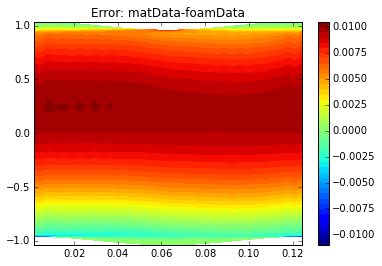

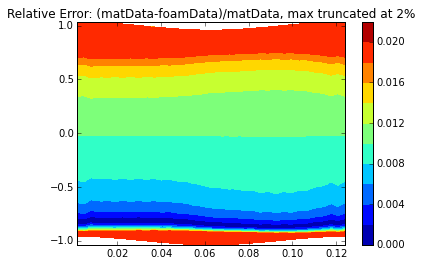

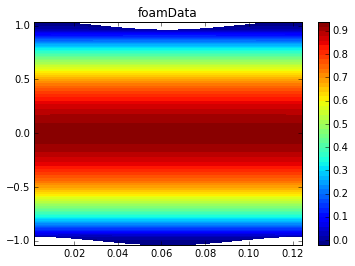

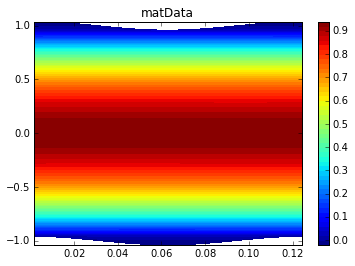

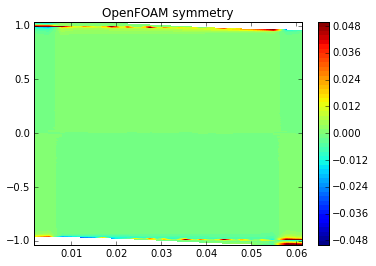

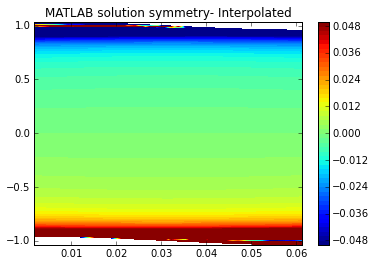

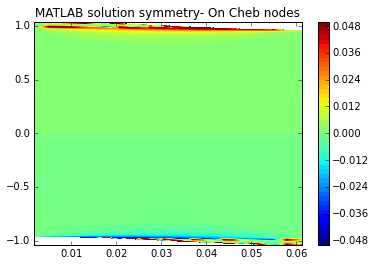

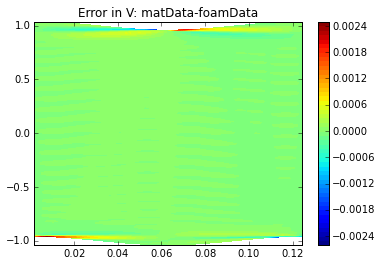

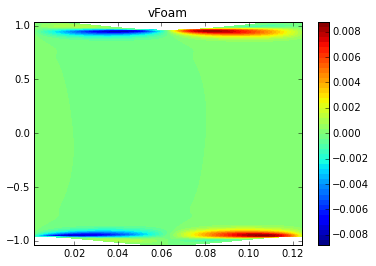

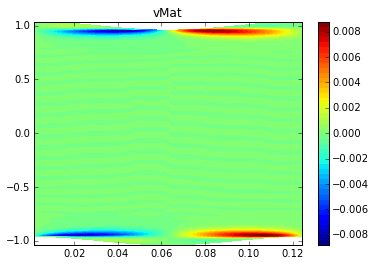

In [6]:
import numpy as np
from flowFieldWavy import *
from myUtils import *

filePath =  '/home/sabarish/OpenFOAM/sabarish-2.4.x/run/wavyLam/ep02/a50/finest/'
endTime = '560/'
pointsName=filePath+'constant/polyMesh/points'
eps = 0.02
a = 50
g= a*eps

x,y,z = readPoints(fName=pointsName, nx = 61,ny=501)
yMax =np.max(y)
yMin = np.min(y)
#h = (yMax-yMin)/2.08
h = 0.1
x = x/h; y =(y-h)/h; z=z/h

import matplotlib.pyplot as plt
%matplotlib inline
vF,pF,paramDict = mapData2ff(g=g, eps=eps, Re=100, theta=0)
print('Volume flux without base:', vF.flux())
print('Volume flux with base:',vF.flux(withBase=True))
print(paramDict)
u = vF.getScalar(nd=0)
v = vF.getScalar(nd=1)
uData = np.zeros(x.shape); vData = np.zeros(x.shape); uUnInt = np.zeros((x.shape[0],x.shape[1],u.N))
for kx in range(x.shape[0]):
    for kz in range(x.shape[1]):
        yBottom = np.min(y[kx,kz])
        yT = y[kx,kz]-yBottom-1.
        uData[kx,kz] = u.getPhysical(xLoc=x[kx,0,0], zLoc=z[0,kz,0], yLoc = yT,withBase=True)
        uUnInt[kx,kz] = u.getPhysical(xLoc=x[kx,0,0], zLoc=z[0,kz,0], withBase=True)
        vData[kx,kz] = v.getPhysical(xLoc=x[kx,0,0], zLoc=z[0,kz,0], yLoc = yT)
        
yUnInt = np.zeros((x.shape[0],u.N))
yCheb = chebdif(u.N,1)[0]
for kx in range(x.shape[0]):
    xLoc = x[kx,0,0]
    yUnInt[kx] = yCheb + 2.*u.flowDict['eps']*np.cos(u.flowDict['alpha']*xLoc)
        
#writeFOAMData(vF,pF)
#'''
uFoam,vFoam,wFoam = readFOAMData(fName=filePath+endTime+'U',nx=60,ny=500)
print('max u in uFoam:',np.max(uFoam))
uFoam = uFoam/0.015
vFoam = vFoam/0.015

plt.figure()
plt.title('Error: matData-foamData')
plt.contourf(x[:,0], y[:,0], uData[:,0]-uFoam[:,0], 50)
plt.colorbar()
plt.figure()
plt.title('Relative Error: (matData-foamData)/matData, max truncated at 2%')
uRel = np.abs((uData[:,0]-uFoam[:,0])/uData[:,0])
uRel[uRel>0.02] = 0.02; uRel[uRel<-0.02] = -0.02
plt.contourf(x[:,0], y[:,0],uRel , 10)
plt.colorbar()
plt.figure()
plt.title('foamData')
plt.contourf(x[:,0], y[:,0], uFoam[:,0], 50)
plt.colorbar()
print('max U velocity from foamData:',np.max(uFoam))
plt.figure()
plt.title('matData')
plt.contourf(x[:,0], y[:,0], uData[:,0], 50)
plt.colorbar()

plt.figure()
plt.title('OpenFOAM symmetry')
nx = x.shape[0]
u1 = uFoam[:nx//2,0]; u2 = uFoam[nx//2:,0,::-1]
udif = (u2-u1)/u1
udif[udif>0.05]=0.05; udif[udif<-0.05] = -0.05
plt.contourf(x[:nx//2,0], y[:nx//2,0],udif , 50)
plt.colorbar()

plt.figure()
plt.title('MATLAB solution symmetry- Interpolated')
nx = x.shape[0]
u1 = uData[:nx//2,0]; u2 = uData[nx//2:,0,::-1]
udif = (u2-u1)/u1
udif[udif>0.05]=0.05; udif[udif<-0.05] = -0.05
plt.contourf(x[:nx//2,0], y[:nx//2,0],udif , 50)
plt.colorbar()

plt.figure()
plt.title('MATLAB solution symmetry- On Cheb nodes')
nx = x.shape[0]
u1 = uUnInt[:nx//2,0]; u2 = uUnInt[nx//2:,0,::-1]
print('a*xLoc/pi for symmetry: ', a*x[:nx//2,0,0]/np.pi)
udif = (u2-u1)/u1
udif[udif>0.05]=0.05; udif[udif<-0.05] = -0.05
plt.contourf(x[:nx//2,0,:u.N], yUnInt[:nx//2],udif , 50)
plt.colorbar()


plt.figure()
plt.title('Error in V: matData-foamData')
plt.contourf(x[:,0], y[:,0], vData[:,0]-vFoam[:,0], 50)
plt.colorbar()
plt.figure()
plt.title('vFoam')
plt.contourf(x[:,0], y[:,0], vFoam[:,0], 50)
plt.colorbar()
plt.figure()
plt.title('vMat')
plt.contourf(x[:,0], y[:,0], vData[:,0], 50)
plt.colorbar()



plt.show()

#'''

### Checking symmetry of a MATLAB solution

In [2]:
from flowFieldWavy import *
import numpy as np
vF,pF = mapData2ff(eps=0.02,g=1.0,Re=100., theta=0)[:2]
a = vF.flowDict['alpha']
for x in np.arange(0.,np.pi/a,np.pi/a/21.):
    print(np.linalg.norm(vF.ifft(xLoc=x)[0] - vF.ifft(xLoc=x+np.pi/a)[0,::-1]) )
#print(vF.ifft(xLoc=0))

1.60125554082e-13
1.60112644336e-13
1.60084459486e-13
1.60042401126e-13
1.59982019586e-13
1.59904635808e-13
1.59901654358e-13
1.59916770834e-13
1.59962648591e-13
1.59790109011e-13
1.59831221832e-13
1.59708190707e-13
1.5977536299e-13
1.59932902939e-13
1.5973343672e-13
1.59897972038e-13
1.59886576258e-13
1.60055238894e-13
1.59960423239e-13
1.60105232668e-13
1.60111730526e-13
